In [3]:
!pip install torch_geometric torch_optimizer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.7 MB/s eta 0:00:00


In [4]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import SNRAdam
from SNRAdam import SNRAdam
import torch_optimizer as optim
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from IPython.display import display

In [5]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())

# Check the dataset
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


In [6]:
data = dataset[0]

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Is undirected: True


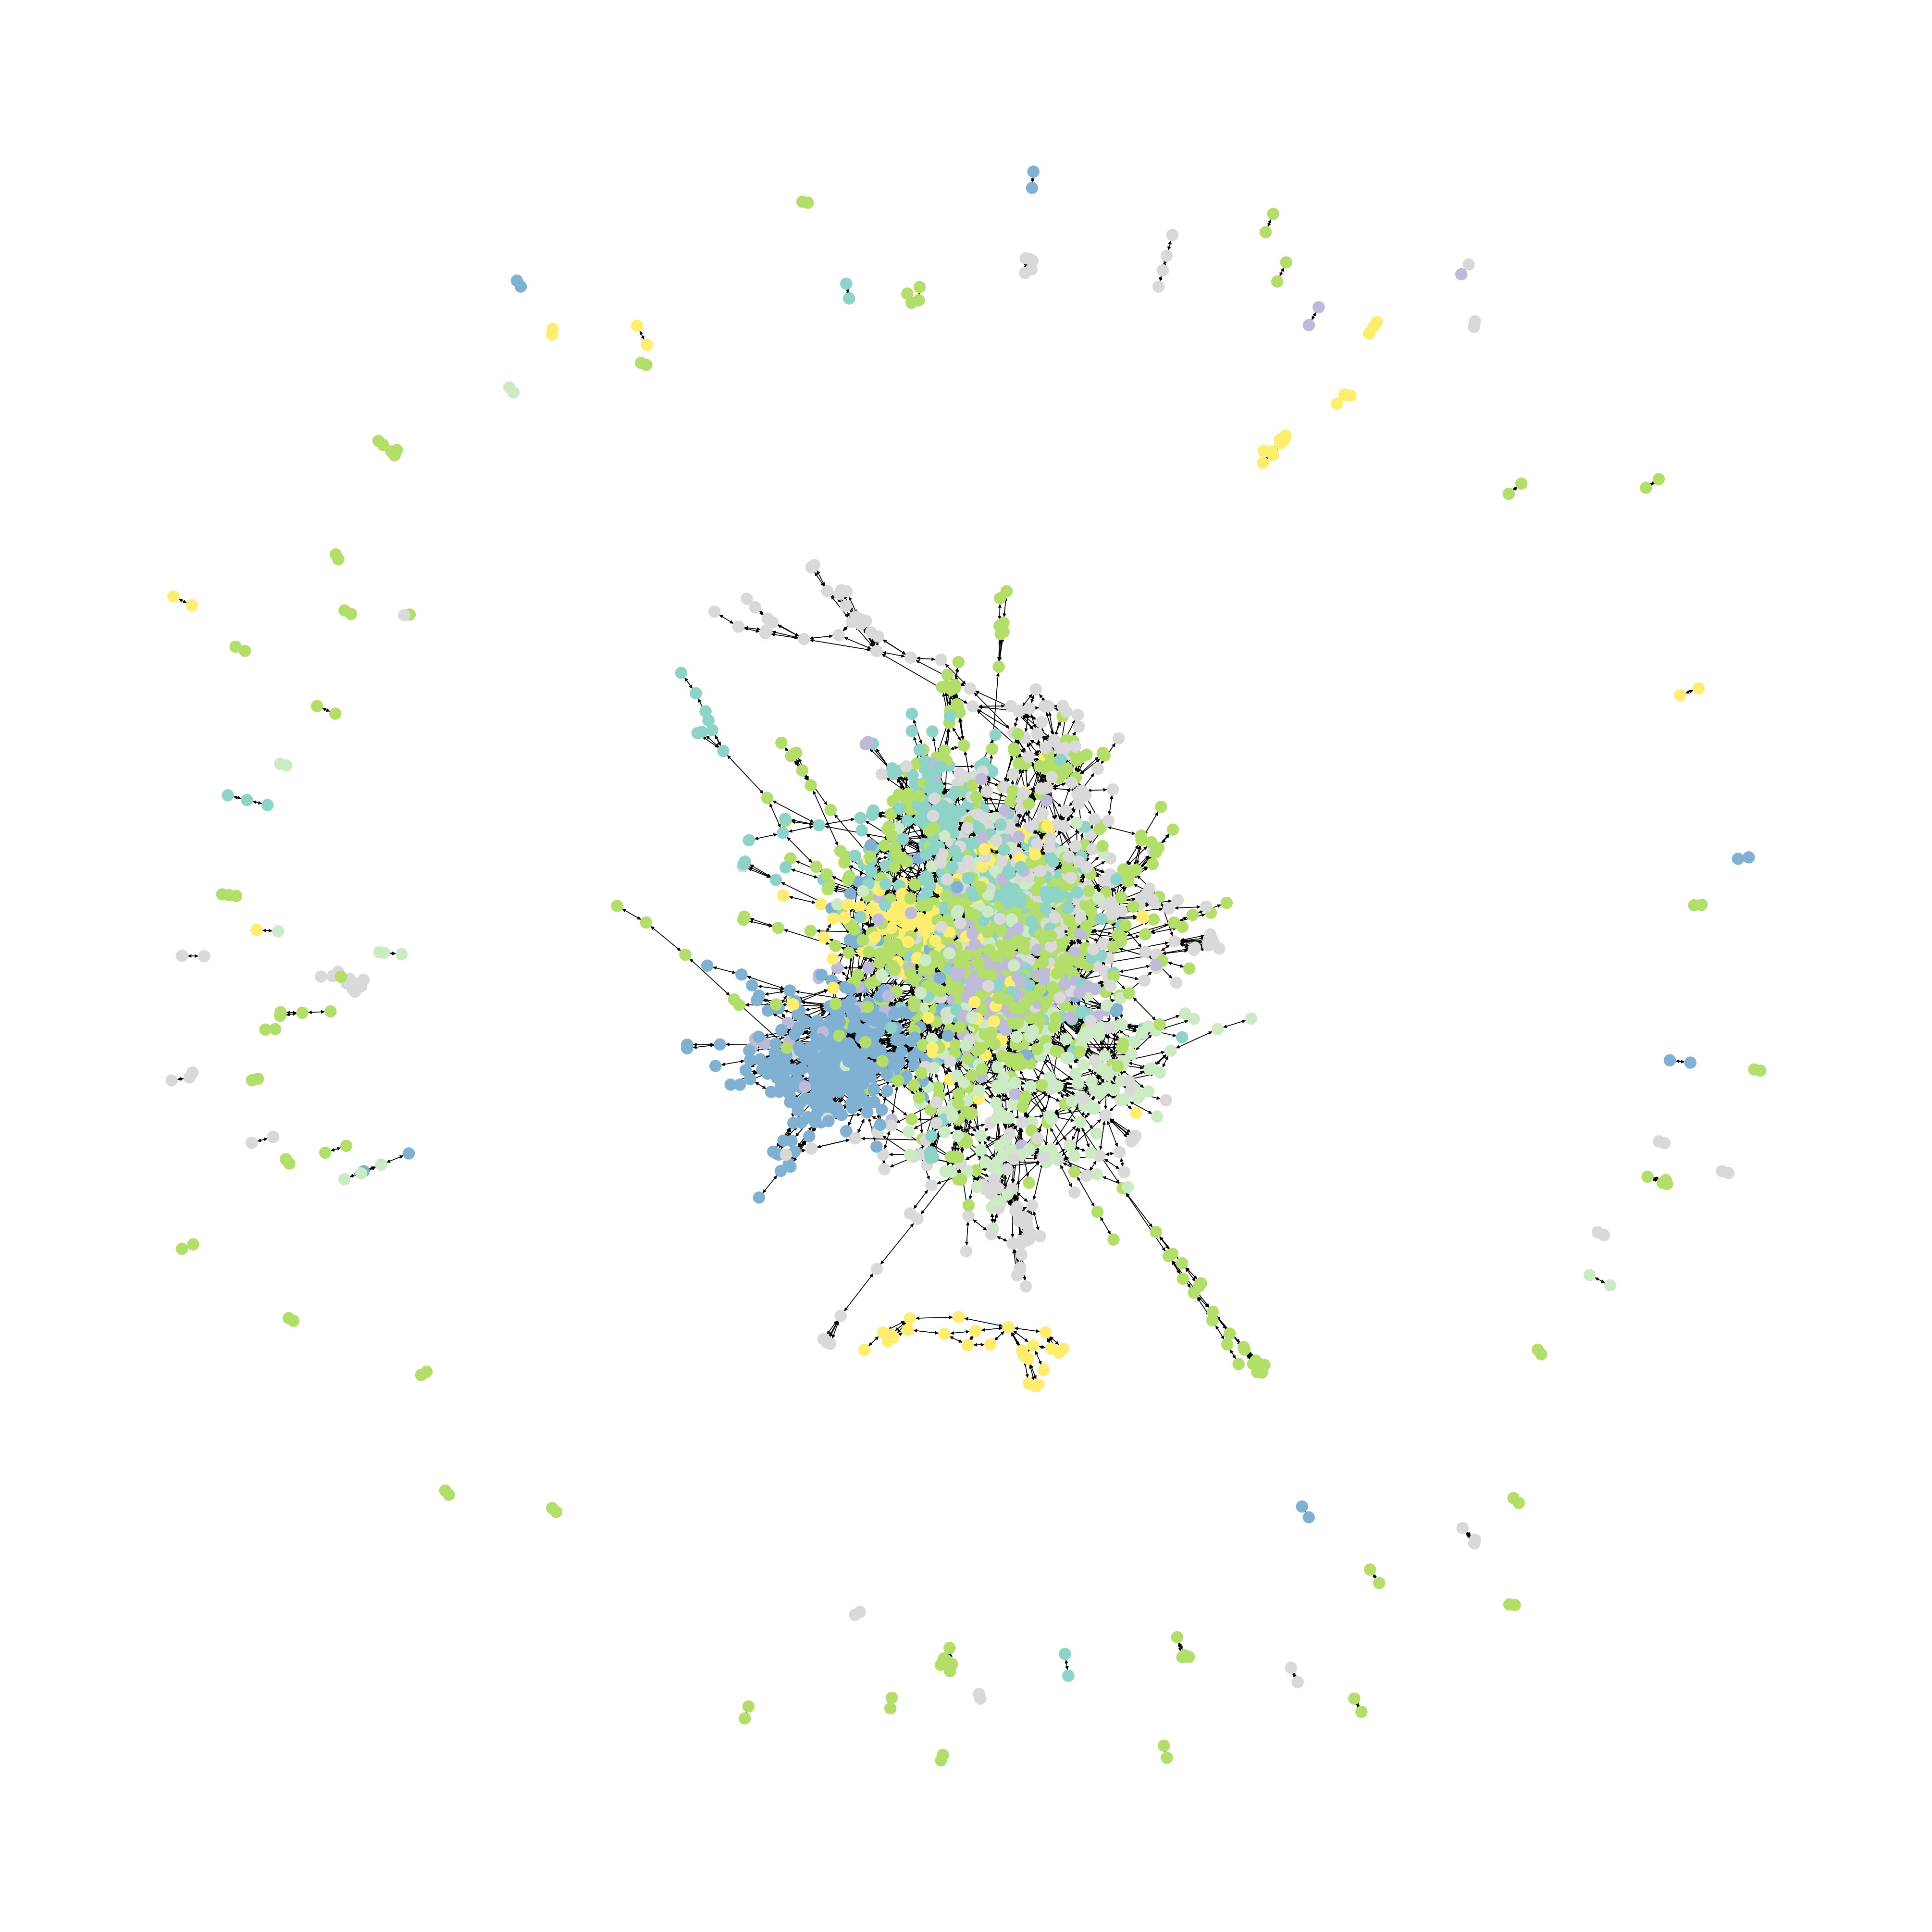

In [7]:
data = dataset[0]
G = to_networkx(data, node_attrs=['x'], edge_attrs=None)

plt.figure(figsize=(40, 40))
nx.draw(G, with_labels=False, node_color=data.y, cmap=plt.get_cmap('Set3'))
plt.show()

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 16)
        self.conv4 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN()
print(model)


GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 16)
  (conv4): GCNConv(16, 7)
)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

In [10]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')

def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

            _, train_pred = out.max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())
            train_accuracies.append(train_acc)

            _, val_pred = out.max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())
            val_accuracies.append(val_acc)

            _, test_pred = out.max(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / int(data.test_mask.sum().item())
            test_accuracies.append(test_acc)

            print(f'Epoch {epoch}/{num_epochs - 1}, '
                  f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model)
                if early_stopping.early_stop:
                    print(f'Early stopping at epoch {epoch}')
                    break

    if early_stopping:
        model.load_state_dict(torch.load('checkpoint.pt'))
    return model, train_accuracies, val_accuracies, test_accuracies


def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, pred = out.max(dim=1)

    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()

    train_report = classification_report(y_true[data.train_mask.cpu().numpy()], y_pred[data.train_mask.cpu().numpy()], output_dict=True)
    test_report = classification_report(y_true[data.test_mask.cpu().numpy()], y_pred[data.test_mask.cpu().numpy()], output_dict=True)

    return train_report, test_report

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    # Evaluate the model and store metrics
    train_metrics, test_metrics = evaluate_model(model, data)

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

In [11]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GCNConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1200
Epoch 1/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1040
Epoch 2/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1000
Epoch 3/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0940
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1280
Epoch 5/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1160
Epoch 6/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1160
Epoch 7/199, Training Accuracy: 0.1643, Validation Accuracy: 0.1220
Epoch 8/199, Training Accuracy: 0.1643, Validation Accuracy: 0.1320
Epoch 9/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1360
Epoch 10/199, Training Accuracy: 0.1929, Validation Accuracy: 0.1520
Early stopping at epoch 10
Train Accuracy: 0.1929, Validation Accuracy: 0.1520, Test Accuracy: 0.1350
-------------------------------

<ipython-input-10-37fd34e2ec98>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 0/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0920
Epoch 1/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0920
Epoch 2/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0920
Epoch 3/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0920
Epoch 4/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0920
Epoch 5/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0920
Epoch 6/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0920
Epoch 7/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0920
Epoch 8/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0920
Epoch 9/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0920
Epoch 10/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0920
Early stopping at epoch 10
Train Accuracy: 0.1500, Validation Accuracy: 0.0920, Test Accuracy: 0.0970
--------------------------------------------------
Optimizer: RMSprop
--------------------------------------------------


<ipython-input-10-37fd34e2ec98>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))
/usr/local/lib/python3.10/dist-packages/

Epoch 0/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1580
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 5/199, Training Accuracy: 0.2643, Validation Accuracy: 0.1440
Epoch 6/199, Training Accuracy: 0.3143, Validation Accuracy: 0.2180
Epoch 7/199, Training Accuracy: 0.2214, Validation Accuracy: 0.1860
Epoch 8/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0740
Epoch 9/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3160
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 11/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1560
Epoch 12/199, Training Accuracy: 0.3000, Validation Accuracy: 0.2000
Epoch 13/199, Training Accuracy: 0.5143, Validation Accuracy: 0.3260
Epoch 14/199, Training Accuracy: 0.6786, Val

<ipython-input-10-37fd34e2ec98>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


--------------------------------------------------
Optimizer: Rprop
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.2643, Validation Accuracy: 0.1500
Epoch 1/199, Training Accuracy: 0.1643, Validation Accuracy: 0.1560
Epoch 2/199, Training Accuracy: 0.2143, Validation Accuracy: 0.1440
Epoch 3/199, Training Accuracy: 0.4357, Validation Accuracy: 0.2740
Epoch 4/199, Training Accuracy: 0.5214, Validation Accuracy: 0.4140
Epoch 5/199, Training Accuracy: 0.5857, Validation Accuracy: 0.4180
Epoch 6/199, Training Accuracy: 0.8071, Validation Accuracy: 0.6200
Epoch 7/199, Training Accuracy: 0.8714, Validation Accuracy: 0.6020
Epoch 8/199, Training Accuracy: 0.8857, Validation Accuracy: 0.7180
Epoch 9/199, Training Accuracy: 0.9071, Validation Accuracy: 0.7580
Epoch 10/199, Training Accuracy: 0.9571, Validation Accuracy: 0.7360
Epoch 11/199, Training Accuracy: 0.9214, Validation Accuracy: 0.7560
Epoch 12/199, Training Accuracy: 0.9643, Validation Accuracy: 0

<ipython-input-10-37fd34e2ec98>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Train Accuracy: 1.0000, Validation Accuracy: 0.7680, Test Accuracy: 0.7980
--------------------------------------------------
Optimizer: Adam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1640
Epoch 2/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1660
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 4/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1840
Epoch 5/199, Training Accuracy: 0.4571, Validation Accuracy: 0.3100
Epoch 6/199, Training Accuracy: 0.4429, Validation Accuracy: 0.3040
Epoch 7/199, Training Accuracy: 0.3429, Validation Accuracy: 0.2600
Epoch 8/199, Training Accuracy: 0.3929, Validation Accuracy: 0.3420
Epoch 9/199, Training Accuracy: 0.3929, Validation Accuracy: 0.4360
Epoch 10/199, Training Accuracy: 0.4000, Validation Accuracy: 0.4220
Epoch 11/199, Training Accuracy: 0.3500, Validation Accura

<ipython-input-10-37fd34e2ec98>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 0/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0760
Epoch 1/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1280
Epoch 2/199, Training Accuracy: 0.1643, Validation Accuracy: 0.1140
Epoch 3/199, Training Accuracy: 0.2786, Validation Accuracy: 0.1820
Epoch 4/199, Training Accuracy: 0.3143, Validation Accuracy: 0.1760
Epoch 5/199, Training Accuracy: 0.5429, Validation Accuracy: 0.3640
Epoch 6/199, Training Accuracy: 0.6357, Validation Accuracy: 0.5420
Epoch 7/199, Training Accuracy: 0.3357, Validation Accuracy: 0.1900
Epoch 8/199, Training Accuracy: 0.3071, Validation Accuracy: 0.1740
Epoch 9/199, Training Accuracy: 0.4571, Validation Accuracy: 0.2260
Epoch 10/199, Training Accuracy: 0.6000, Validation Accuracy: 0.3660
Epoch 11/199, Training Accuracy: 0.5714, Validation Accuracy: 0.3360
Epoch 12/199, Training Accuracy: 0.7143, Validation Accuracy: 0.5500
Epoch 13/199, Training Accuracy: 0.6929, Validation Accuracy: 0.4000
Epoch 14/199, Training Accuracy: 0.7643, Val

<ipython-input-10-37fd34e2ec98>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 0/199, Training Accuracy: 0.0786, Validation Accuracy: 0.0920
Epoch 1/199, Training Accuracy: 0.0929, Validation Accuracy: 0.0880
Epoch 2/199, Training Accuracy: 0.0857, Validation Accuracy: 0.0920
Epoch 3/199, Training Accuracy: 0.0929, Validation Accuracy: 0.0860
Epoch 4/199, Training Accuracy: 0.0929, Validation Accuracy: 0.0880
Epoch 5/199, Training Accuracy: 0.0929, Validation Accuracy: 0.0940
Epoch 6/199, Training Accuracy: 0.0929, Validation Accuracy: 0.0960
Epoch 7/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1000
Epoch 8/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1040
Epoch 9/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1060
Epoch 10/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1040
Early stopping at epoch 10


<ipython-input-10-37fd34e2ec98>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))
/usr/local/lib/python3.10/dist-packages/

Train Accuracy: 0.1286, Validation Accuracy: 0.1060, Test Accuracy: 0.1130
--------------------------------------------------
Optimizer: RAdam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0700
Epoch 1/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0720
Epoch 2/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0720
Epoch 3/199, Training Accuracy: 0.1643, Validation Accuracy: 0.0700
Epoch 4/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0700
Epoch 5/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0720
Epoch 6/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0700
Epoch 7/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0600
Epoch 8/199, Training Accuracy: 0.1714, Validation Accuracy: 0.0580
Epoch 9/199, Training Accuracy: 0.1786, Validation Accuracy: 0.0580
Epoch 10/199, Training Accuracy: 0.1786, Validation Accuracy: 0.0580
Early stopping at epoch 10


<ipython-input-10-37fd34e2ec98>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))
/usr/local/lib/python3.10/dist-packages/

Train Accuracy: 0.1786, Validation Accuracy: 0.0720, Test Accuracy: 0.0910
--------------------------------------------------
Optimizer: NAdam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1786, Validation Accuracy: 0.0860
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 2/199, Training Accuracy: 0.3500, Validation Accuracy: 0.2220
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 4/199, Training Accuracy: 0.6214, Validation Accuracy: 0.4120
Epoch 5/199, Training Accuracy: 0.1500, Validation Accuracy: 0.0720
Epoch 6/199, Training Accuracy: 0.6571, Validation Accuracy: 0.4100
Epoch 7/199, Training Accuracy: 0.3000, Validation Accuracy: 0.1040
Epoch 8/199, Training Accuracy: 0.4357, Validation Accuracy: 0.2200
Epoch 9/199, Training Accuracy: 0.3214, Validation Accuracy: 0.1560
Epoch 10/199, Training Accuracy: 0.5857, Validation Accuracy: 0.3540
Epoch 11/199, Training Accuracy: 0.8071, Validation Accur

<ipython-input-10-37fd34e2ec98>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 0/199, Training Accuracy: 0.3000, Validation Accuracy: 0.1900
Epoch 1/199, Training Accuracy: 0.2357, Validation Accuracy: 0.1400
Epoch 2/199, Training Accuracy: 0.3000, Validation Accuracy: 0.1400
Epoch 3/199, Training Accuracy: 0.4643, Validation Accuracy: 0.2340
Epoch 4/199, Training Accuracy: 0.5429, Validation Accuracy: 0.2780
Epoch 5/199, Training Accuracy: 0.5500, Validation Accuracy: 0.3260
Epoch 6/199, Training Accuracy: 0.5429, Validation Accuracy: 0.3080
Epoch 7/199, Training Accuracy: 0.6071, Validation Accuracy: 0.3780
Epoch 8/199, Training Accuracy: 0.6929, Validation Accuracy: 0.4540
Epoch 9/199, Training Accuracy: 0.6286, Validation Accuracy: 0.4160
Epoch 10/199, Training Accuracy: 0.6429, Validation Accuracy: 0.4160
Epoch 11/199, Training Accuracy: 0.7143, Validation Accuracy: 0.4800
Epoch 12/199, Training Accuracy: 0.7500, Validation Accuracy: 0.5300
Epoch 13/199, Training Accuracy: 0.7714, Validation Accuracy: 0.5700
Epoch 14/199, Training Accuracy: 0.7857, Val

<ipython-input-10-37fd34e2ec98>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 1/199, Training Accuracy: 0.3500, Validation Accuracy: 0.3180
Epoch 2/199, Training Accuracy: 0.3786, Validation Accuracy: 0.3000
Epoch 3/199, Training Accuracy: 0.2714, Validation Accuracy: 0.2240
Epoch 4/199, Training Accuracy: 0.3643, Validation Accuracy: 0.2780
Epoch 5/199, Training Accuracy: 0.6071, Validation Accuracy: 0.5320
Epoch 6/199, Training Accuracy: 0.6929, Validation Accuracy: 0.6220
Epoch 7/199, Training Accuracy: 0.7357, Validation Accuracy: 0.6460
Epoch 8/199, Training Accuracy: 0.7429, Validation Accuracy: 0.6460
Epoch 9/199, Training Accuracy: 0.8714, Validation Accuracy: 0.7340
Epoch 10/199, Training Accuracy: 0.9071, Validation Accuracy: 0.7440
Epoch 11/199, Training Accuracy: 0.9286, Validation Accuracy: 0.7400
Epoch 12/199, Training Accuracy: 0.9286, Validation Accuracy: 0.7540
Epoch 13/199, Training Accuracy: 0.9286, Validation Accuracy: 0.7740
Epoch 14/199, Training Accuracy: 0.9500, Validation Accuracy: 0.7620
Epoch 15/199, Training Accuracy: 0.9571, Va

<ipython-input-10-37fd34e2ec98>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


In [12]:
# Convert metrics to DataFrame for better visualization
metrics_list = []
test_metrics_list = []

for name in all_train_metrics.keys():
    train_report = all_train_metrics[name]
    test_report = all_test_metrics[name]

    row = {
        'Optimizer': name,
        'Train Accuracy': train_report['accuracy'],
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_report['accuracy'],
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    }
    metrics_list.append(row)
    test_metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(metrics_df)


Evaluation Metrics:
   Optimizer  Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0       ASGD        0.128571         0.121693      0.128571        0.118358   
1      LBFGS        0.150000         0.121745      0.150000        0.111237   
2    RMSprop        0.921429         0.936617      0.921429        0.922181   
3      Rprop        0.914286         0.916975      0.914286        0.913514   
4       Adam        0.971429         0.976190      0.971429        0.971767   
5    Adagrad        0.985714         0.987013      0.985714        0.985871   
6   Adadelta        0.078571         0.105232      0.078571        0.056989   
7      RAdam        0.171429         0.047943      0.171429        0.070093   
8      NAdam        0.978571         0.979252      0.978571        0.978741   
9      AdamW        0.942857         0.948058      0.942857        0.944073   
10   SNRAdam        0.957143         0.959771      0.957143        0.957438   

    Test Accuracy  Test Precis

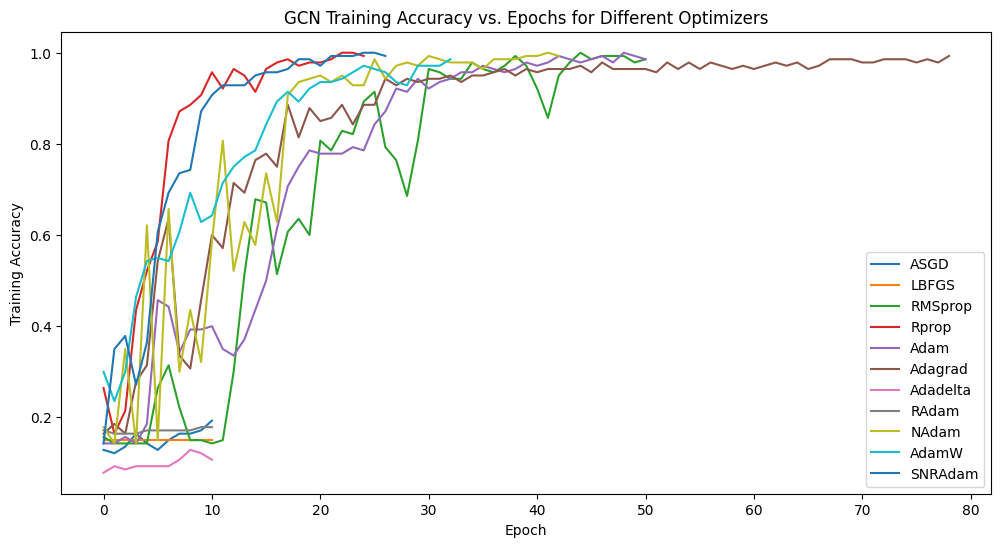

In [13]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('GCN Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

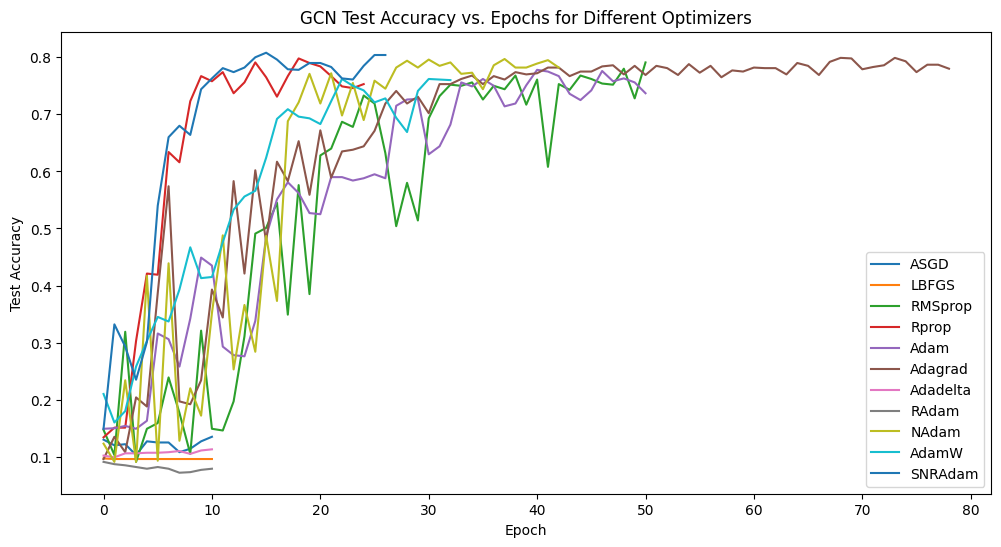

In [14]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('GCN Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

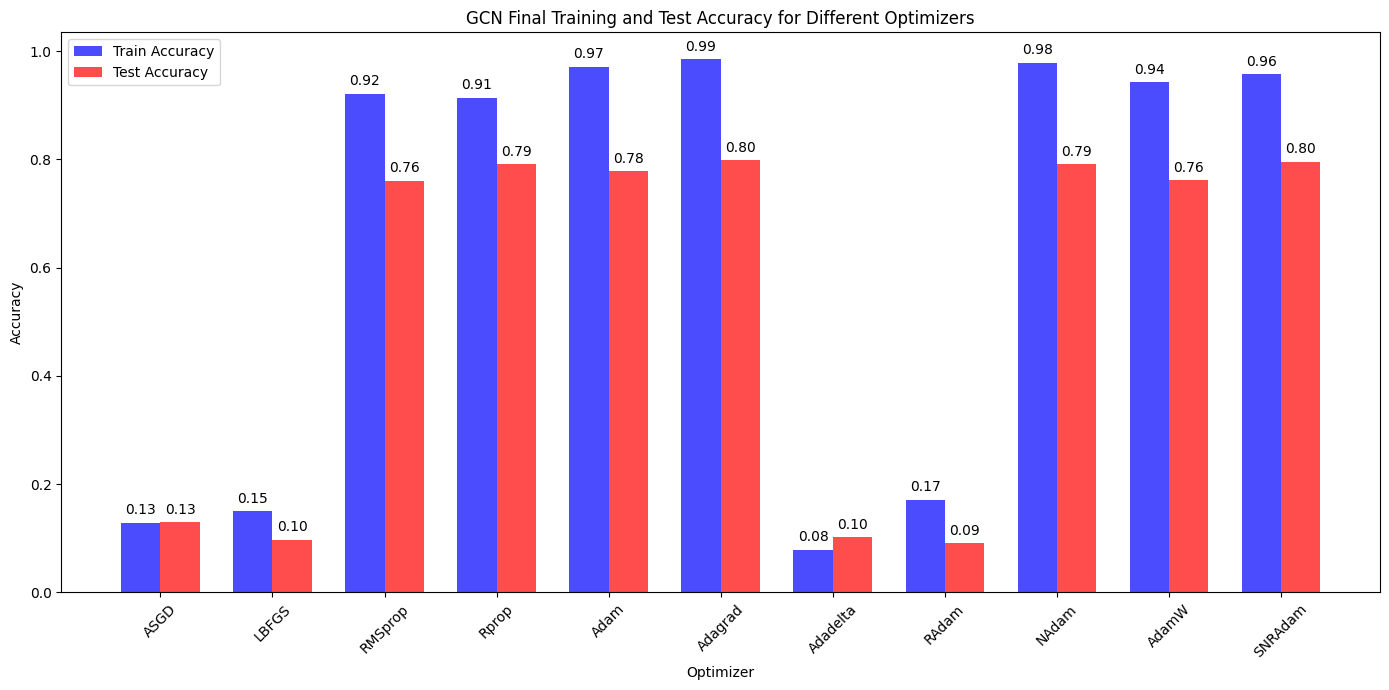

In [15]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics_list)

# Extract accuracies for plotting
train_accuracies = metrics_df['Train Accuracy']
test_accuracies = metrics_df['Test Accuracy']
optimizers_list = metrics_df['Optimizer']

# Convert to lists for plotting
x = np.arange(len(optimizers_list))
bar_width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_accuracies, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_accuracies, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('GCN Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_node_features, 128, heads=16, dropout=0.3)
        self.conv2 = GATConv(128 * 16, 64, heads=8, dropout=0.3)
        self.conv3 = GATConv(64 * 8, 16, heads=4, dropout=0.3)
        self.conv4 = GATConv(16 * 4, dataset.num_classes, heads=1, concat=False, dropout=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT()
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model, epoch):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model = model.state_dict()
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping at epoch {epoch}")

    def load_best_model(self, model):
        model.load_state_dict(self.best_model)

def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            _, train_pred = model(data).max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())
            train_accuracies.append(train_acc)

            _, val_pred = model(data).max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())
            val_accuracies.append(val_acc)

            _, test_pred = out.max(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / int(data.test_mask.sum().item())
            test_accuracies.append(test_acc)

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}/{num_epochs - 1}, '
                   f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model, epoch)
                if early_stopping.early_stop:
                    early_stopping.load_best_model(model)
                    break

    return model, train_accuracies, val_accuracies, test_accuracies

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, pred = out.max(dim=1)

    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()

    train_report = classification_report(y_true[data.train_mask.cpu().numpy()], y_pred[data.train_mask.cpu().numpy()], output_dict=True)
    test_report = classification_report(y_true[data.test_mask.cpu().numpy()], y_pred[data.test_mask.cpu().numpy()], output_dict=True)

    return train_report, test_report

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    # Evaluate the model and store metrics
    train_metrics, test_metrics = evaluate_model(model, data)

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

GAT(
  (conv1): GATConv(1433, 128, heads=16)
  (conv2): GATConv(2048, 64, heads=8)
  (conv3): GATConv(512, 16, heads=4)
  (conv4): GATConv(64, 7, heads=1)
)


In [17]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GATConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1400
Epoch 1/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1540
Epoch 2/199, Training Accuracy: 0.1643, Validation Accuracy: 0.1420
Epoch 3/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1520
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1580
Epoch 5/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1580
Epoch 6/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1260
Epoch 7/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1400
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1520
Epoch 9/199, Training Accuracy: 0.1786, Validation Accuracy: 0.1340
Epoch 10/199, Training Accuracy: 0.1929, Validation Accuracy: 0.1600
Epoch 11/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1480
Epoch 12/199, Training Accuracy: 0.1571, Validation Accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

--------------------------------------------------
Optimizer: Rprop
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.4000, Validation Accuracy: 0.2560
Epoch 1/199, Training Accuracy: 0.2857, Validation Accuracy: 0.3940
Epoch 2/199, Training Accuracy: 0.2000, Validation Accuracy: 0.0760
Epoch 3/199, Training Accuracy: 0.5000, Validation Accuracy: 0.3280
Epoch 4/199, Training Accuracy: 0.5857, Validation Accuracy: 0.4840
Epoch 5/199, Training Accuracy: 0.7929, Validation Accuracy: 0.6580
Epoch 6/199, Training Accuracy: 0.8500, Validation Accuracy: 0.6660
Epoch 7/199, Training Accuracy: 0.8643, Validation Accuracy: 0.6160
Epoch 8/199, Training Accuracy: 0.9357, Validation Accuracy: 0.7140
Epoch 9/199, Training Accuracy: 0.9500, Validation Accuracy: 0.7800
Epoch 10/199, Training Accuracy: 0.9714, Validation Accuracy: 0.7640
Epoch 11/199, Training Accuracy: 0.9571, Validation Accuracy: 0.7740
Epoch 12/199, Training Accuracy: 0.9571, Validation Accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------------------
Optimizer: RAdam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1857, Validation Accuracy: 0.2280
Epoch 1/199, Training Accuracy: 0.1929, Validation Accuracy: 0.2100
Epoch 2/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1840
Epoch 3/199, Training Accuracy: 0.1929, Validation Accuracy: 0.1760
Epoch 4/199, Training Accuracy: 0.1786, Validation Accuracy: 0.1620
Epoch 5/199, Training Accuracy: 0.3429, Validation Accuracy: 0.2780
Epoch 6/199, Training Accuracy: 0.7071, Validation Accuracy: 0.5240
Epoch 7/199, Training Accuracy: 0.8071, Validation Accuracy: 0.6000
Epoch 8/199, Training Accuracy: 0.8143, Validation Accuracy: 0.6240
Epoch 9/199, Training Accuracy: 0.8286, Validation Accuracy: 0.6440
Epoch 10/199, Training Accuracy: 0.8286, Validation Accuracy: 0.6400
Epoch 11/199, Training Accuracy: 0.8143, Validation Accuracy: 0.6320
Epoch 12/199, Training Accuracy: 0.8143, Validation Accuracy: 0

In [18]:
# Convert metrics to DataFrame for better visualization
metrics_list = []
test_metrics_list = []

for name in all_train_metrics.keys():
    train_report = all_train_metrics[name]
    test_report = all_test_metrics[name]

    row = {
        'Optimizer': name,
        'Train Accuracy': train_report['accuracy'],
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_report['accuracy'],
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    }
    metrics_list.append(row)
    test_metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(metrics_df)


Evaluation Metrics:
   Optimizer  Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0       ASGD        0.200000         0.189378      0.200000        0.186209   
1      LBFGS        0.150000         0.101202      0.150000        0.112878   
2    RMSprop        0.142857         0.020408      0.142857        0.035714   
3      Rprop        1.000000         1.000000      1.000000        1.000000   
4       Adam        0.978571         0.980210      0.978571        0.978130   
5    Adagrad        0.985714         0.986054      0.985714        0.985710   
6   Adadelta        0.192857         0.159108      0.192857        0.129638   
7      RAdam        1.000000         1.000000      1.000000        1.000000   
8      NAdam        0.985714         0.987013      0.985714        0.985678   
9      AdamW        0.985714         0.986395      0.985714        0.985705   
10   SNRAdam        0.992857         0.993197      0.992857        0.992853   

    Test Accuracy  Test Precis

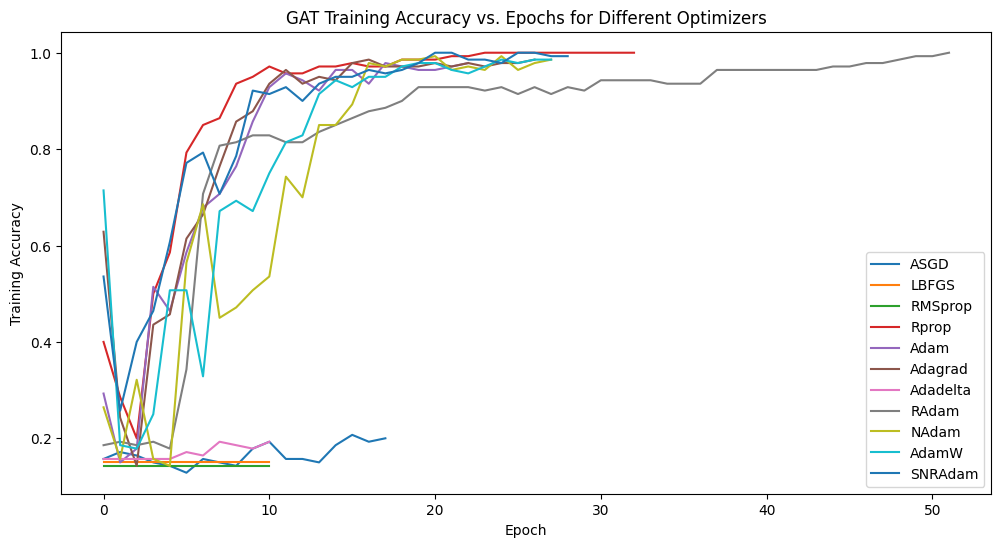

In [19]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('GAT Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

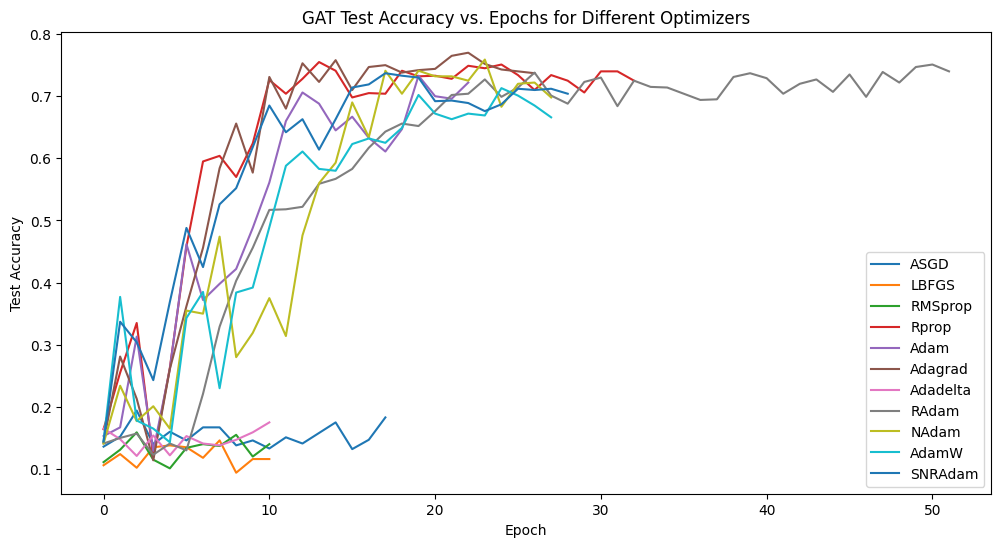

In [21]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('GAT Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

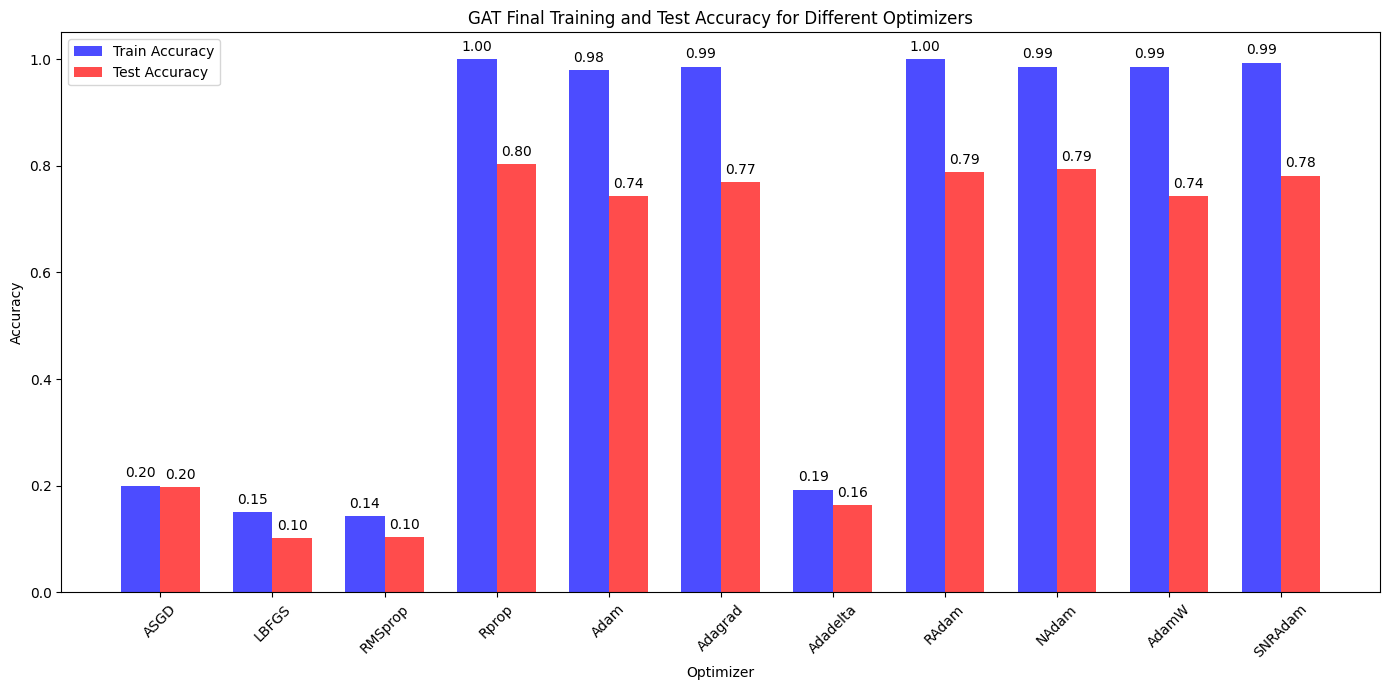

In [22]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics_list)

# Extract accuracies for plotting
train_accuracies = metrics_df['Train Accuracy']
test_accuracies = metrics_df['Test Accuracy']
optimizers_list = metrics_df['Optimizer']

# Convert to lists for plotting
x = np.arange(len(optimizers_list))
bar_width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_accuracies, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_accuracies, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('GAT Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
# https://arxiv.org/abs/1706.02216
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.conv3 = SAGEConv(64, 16)
        self.conv4 = SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE()
print(model)

GraphSAGE(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (conv2): SAGEConv(128, 64, aggr=mean)
  (conv3): SAGEConv(64, 16, aggr=mean)
  (conv4): SAGEConv(16, 7, aggr=mean)
)


In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import pandas as pd

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.conv3 = SAGEConv(64, 16)
        self.conv4 = SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(x)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE()
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model, epoch):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model = model.state_dict()
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping at epoch {epoch}")

    def load_best_model(self, model):
        model.load_state_dict(self.best_model)

def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            _, train_pred = model(data).max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())
            train_accuracies.append(train_acc)

            _, val_pred = model(data).max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())
            val_accuracies.append(val_acc)

            _, test_pred = out.max(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / int(data.test_mask.sum().item())
            test_accuracies.append(test_acc)

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}/{num_epochs - 1}, '
                   f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model, epoch)
                if early_stopping.early_stop:
                    early_stopping.load_best_model(model)
                    break

    return model, train_accuracies, val_accuracies, test_accuracies

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, pred = out.max(dim=1)

    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()

    train_report = classification_report(y_true[data.train_mask.cpu().numpy()], y_pred[data.train_mask.cpu().numpy()], output_dict=True)
    test_report = classification_report(y_true[data.test_mask.cpu().numpy()], y_pred[data.test_mask.cpu().numpy()], output_dict=True)

    return train_report, test_report

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())
    test_accuracies.append(test_acc)

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    # Evaluate the model and store metrics
    train_metrics, test_metrics = evaluate_model(model, data)

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam' : SNRAdam(model.parameters(), lr=0.01)
}

GraphSAGE(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (conv2): SAGEConv(128, 64, aggr=mean)
  (conv3): SAGEConv(64, 16, aggr=mean)
  (conv4): SAGEConv(16, 7, aggr=mean)
)


In [86]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, SAGEConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Early stopping at epoch 11
Train Accuracy: 0.1429, Validation Ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

--------------------------------------------------
Optimizer: LBFGS
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Early stopping at epoch 11
Train Accuracy: 0.1429, Validation A

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

--------------------------------------------------
Optimizer: RMSprop
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1140
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 2/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1580
Epoch 3/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1620
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1560
Epoch 5/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1560
Epoch 6/199, Training Accuracy: 0.2071, Validation Accuracy: 0.1600
Epoch 7/199, Training Accuracy: 0.3214, Validation Accuracy: 0.2320
Epoch 8/199, Training Accuracy: 0.2357, Validation Accuracy: 0.1620
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 10/199, Training Accuracy: 0.2500, Validation Accuracy: 0.2160
Epoch 11/199, Training Accuracy: 0.2786, Validation Accuracy: 0.2080
Epoch 12/199, Training Accuracy: 0.3929, Validation Accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

--------------------------------------------------
Optimizer: RAdam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0580
Epoch 12/199, Training Accuracy: 0.1429, Validation Accuracy: 0

In [26]:
# Convert metrics to DataFrame for better visualization
metrics_list = []
test_metrics_list = []

for name in all_train_metrics.keys():
    train_report = all_train_metrics[name]
    test_report = all_test_metrics[name]

    row = {
        'Optimizer': name,
        'Train Accuracy': train_report['accuracy'],
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_report['accuracy'],
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    }
    metrics_list.append(row)
    test_metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(metrics_df)


Evaluation Metrics:
   Optimizer  Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0       ASGD        0.142857         0.020408      0.142857        0.035714   
1      LBFGS        0.142857         0.020408      0.142857        0.035714   
2    RMSprop        0.992857         0.993197      0.992857        0.992853   
3      Rprop        0.992857         0.993197      0.992857        0.992853   
4       Adam        0.950000         0.953300      0.950000        0.949467   
5    Adagrad        1.000000         1.000000      1.000000        1.000000   
6   Adadelta        0.142857         0.020408      0.142857        0.035714   
7      RAdam        0.142857         0.020408      0.142857        0.035714   
8      NAdam        1.000000         1.000000      1.000000        1.000000   
9      AdamW        0.942857         0.956160      0.942857        0.941273   
10   SNRAdam        0.985714         0.986054      0.985714        0.985710   

    Test Accuracy  Test Precis

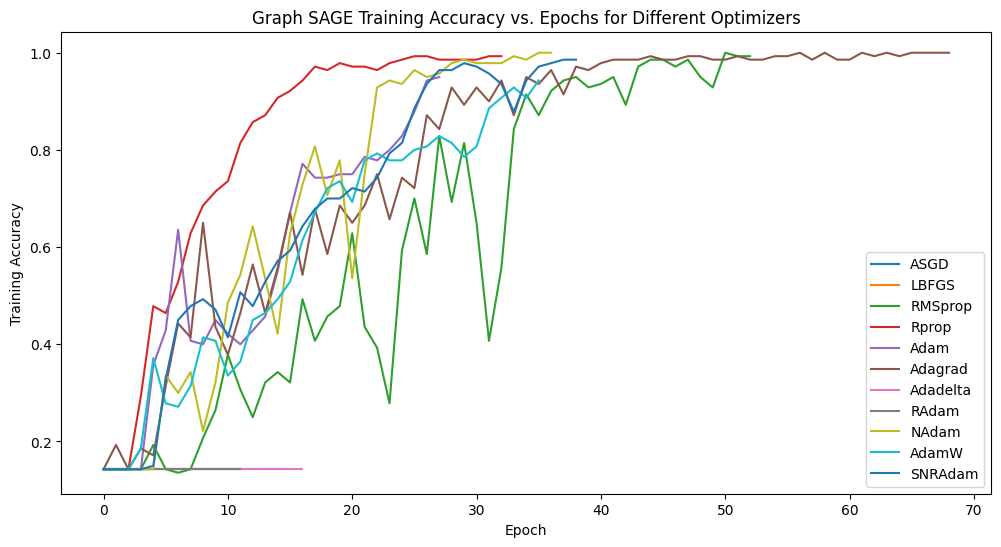

In [27]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Graph SAGE Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

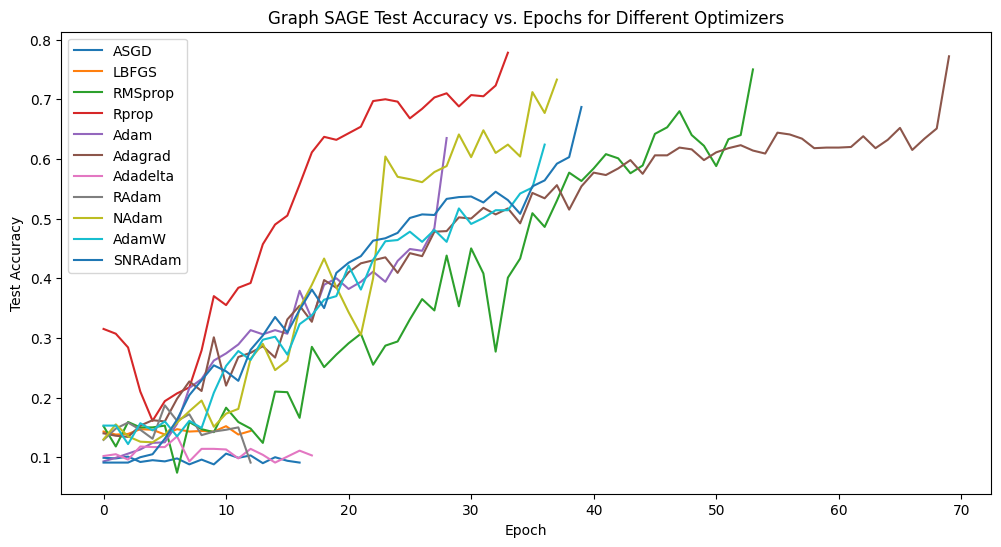

In [28]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Graph SAGE Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

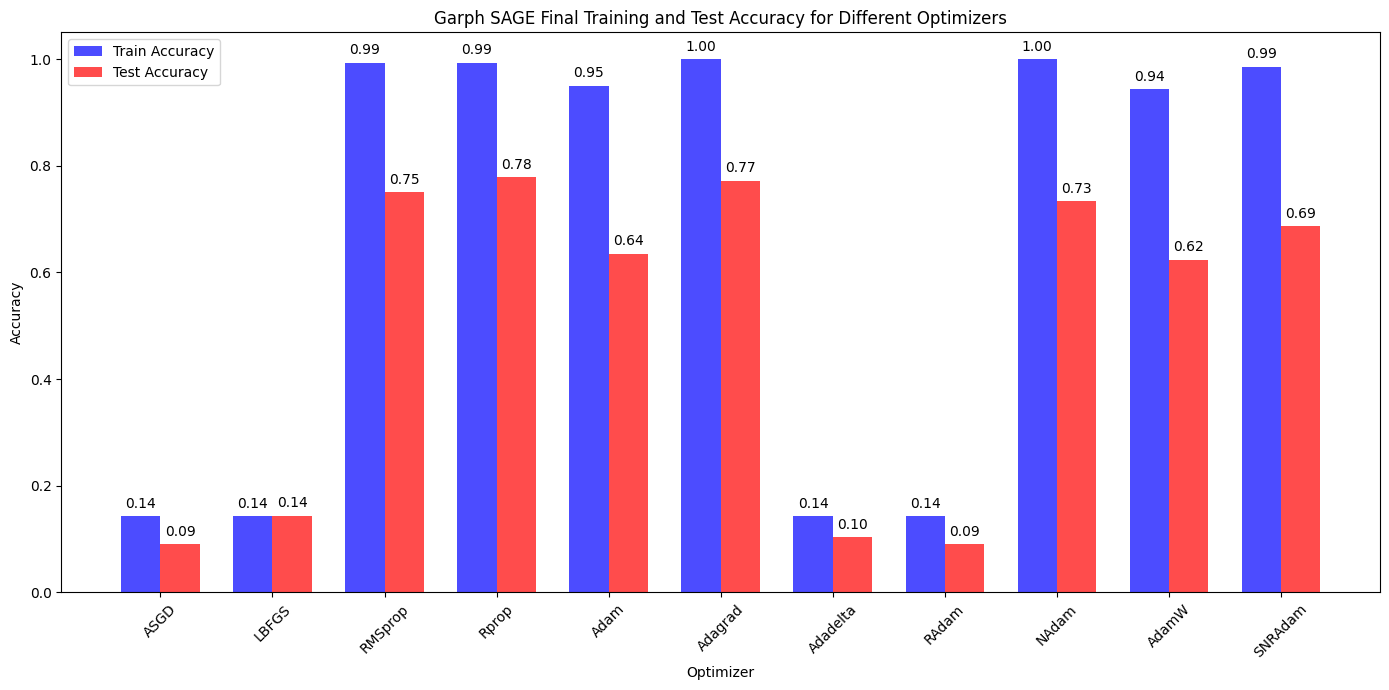

In [29]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics_list)

# Extract accuracies for plotting
train_accuracies = metrics_df['Train Accuracy']
test_accuracies = metrics_df['Test Accuracy']
optimizers_list = metrics_df['Optimizer']

# Convert to lists for plotting
x = np.arange(len(optimizers_list))
bar_width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_accuracies, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_accuracies, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('Garph SAGE Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE
import torch.nn as nn
import torch.optim as optim

class GCNEncoder(torch.nn.Module):
    def __init__(self):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32, cached=True)
        self.conv2 = GCNConv(32, 16, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2(x, edge_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_channels = 16
num_features = dataset.num_features

model = GAE(GCNEncoder()).to(device)
x = data.x.to(device)
edge_index = data.edge_index.to(device)
criterion = nn.CrossEntropyLoss()

# Define the NodeClassifier
class NodeClassifier(nn.Module):
    def __init__(self):
        super(NodeClassifier, self).__init__()
        self.linear = nn.Linear(16, dataset.num_classes)

    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)

classifier = NodeClassifier().to(device)
criterion = nn.CrossEntropyLoss()
labels = data.y.to(device)
train_mask = data.train_mask.to(device)
val_mask = data.val_mask.to(device)
test_mask = data.test_mask.to(device)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, edge_index)
    loss = model.recon_loss(z, edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)

def evaluate_model(embeddings, mask):
    classifier.eval()
    with torch.no_grad():
        out = classifier(embeddings)
        pred = out[mask].max(1)[1]
        acc = pred.eq(labels[mask]).sum().item() / mask.sum().item()
    return acc

def train_classifier():
    classifier.train()
    optimizer.zero_grad()
    out = classifier(embeddings)
    loss = criterion(out[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test_classifier(mask):
    classifier.eval()
    with torch.no_grad():
        out = classifier(embeddings)
        pred = out[mask].max(1)[1]
        acc = pred.eq(labels[mask]).sum().item() / mask.sum().item()
    return acc

def train_model(model, criterion, optimizer, data, num_epochs=25, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        z = model.encode(data.x.to(device), data.edge_index.to(device))
        loss = model.recon_loss(z, data.edge_index.to(device))
        loss.backward()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                z = model.encode(data.x.to(device), data.edge_index.to(device))
                loss = model.recon_loss(z, data.edge_index.to(device))
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        embeddings = model.encode(data.x.to(device), data.edge_index.to(device)).detach()
        train_acc = evaluate_model(embeddings, data.train_mask)
        val_acc = evaluate_model(embeddings, data.val_mask)
        test_acc = evaluate_model(embeddings, data.test_mask)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch}/{num_epochs - 1}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

        if early_stopping:
            early_stopping(val_acc, model, epoch)
            if early_stopping.early_stop:
                early_stopping.load_best_model(model)
                break

    return model, train_accuracies, val_accuracies, test_accuracies

def evaluate_classification_performance(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model.encode(data.x.to(device), data.edge_index.to(device)).detach()
        out = classifier(embeddings)
        _, pred = out.max(dim=1)

    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()

    train_report = classification_report(y_true[data.train_mask.cpu().numpy()], y_pred[data.train_mask.cpu().numpy()], output_dict=True)
    test_report = classification_report(y_true[data.test_mask.cpu().numpy()], y_pred[data.test_mask.cpu().numpy()], output_dict=True)

    return train_report, test_report

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=25, patience=10):

    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    embeddings = model.encode(data.x.to(device), data.edge_index.to(device)).detach()
    train_acc = evaluate_model(embeddings, data.train_mask)
    val_acc = evaluate_model(embeddings, data.val_mask)
    test_acc = evaluate_model(embeddings, data.test_mask)

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    # Evaluate the model and store metrics
    train_metrics, test_metrics = evaluate_classification_performance(model, data)

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics

# Different optimizers
lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam': SNRAdam(model.parameters(), lr=lr)
}

In [34]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GAE)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.3160, Test Accuracy: 0.3190
-------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.3160, Test Accuracy: 0.3190
--------------------------------------------------
Optimizer: RMSprop
--------------------------------------------------
Epoch 0/199, Training Accura

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.3160, Test Accuracy: 0.3190
--------------------------------------------------
Optimizer: Rprop
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3180


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 2/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3100
Epoch 3/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3060
Epoch 4/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3140
Epoch 5/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3120
Epoch 6/199, Training Accuracy: 0.1786, Validation Accuracy: 0.2920
Epoch 7/199, Training Accuracy: 0.1857, Validation Accuracy: 0.2660
Epoch 8/199, Training Accuracy: 0.1929, Validation Accuracy: 0.2620
Epoch 9/199, Training Accuracy: 0.2143, Validation Accuracy: 0.2800
Epoch 10/199, Training Accuracy: 0.2143, Validation Accuracy: 0.3040
Epoch 11/199, Training Accuracy: 0.2214, Validation Accuracy: 0.3020
Epoch 12/199, Training Accuracy: 0.2357, Validation Accuracy: 0.2960
Epoch 13/199, Training Accuracy: 0.2143, Validation Accuracy: 0.3000
Epoch 14/199, Training Accuracy: 0.2286, Validation Accuracy: 0.3040
Epoch 15/199, Training Accuracy: 0.2571, Validation Accuracy: 0.3480
Epoch 16/199, Training Accuracy: 0.2357, V

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.3160, Test Accuracy: 0.3190
--------------------------------------------------
Optimizer: Adagrad
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.3160, Test Accuracy: 0.3190
--------------------------------------------------
Optimizer: Adadelta
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.3160, Test Accuracy: 0.3190
--------------------------------------------------
Optimizer: RAdam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.3160, Test Accuracy: 0.3190
--------------------------------------------------
Optimizer: NAdam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.3160, Test Accuracy: 0.3190
--------------------------------------------------
Optimizer: AdamW
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 3/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3140
Epoch 4/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3100
Epoch 5/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3140
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3140
Epoch 11/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3120
Epoch 12/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3100
Epoch 13/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3100
Epoch 14/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3100
Early stopping at epoch 14
Train Accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

--------------------------------------------------
Optimizer: SNRAdam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3180
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3180
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3180
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3180
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.3160
Epoch 8/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3160
Epoch 9/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3140
Epoch 10/199, Training Accuracy: 0.1500, Validation Accuracy: 0.3100
Epoch 11/199, Training Accuracy: 0.1571, Validation Accuracy: 0.2940
Epoch 12/199, Training Accuracy: 0.1714, Validation Accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [31]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GAE)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.1220, Test Accuracy: 0.1300
-------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 12/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Early stopping at epoch 12
Train Accuracy: 0.1429, Validation Accuracy: 0.1220, Test Accuracy: 0.1300
-----------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.1220, Test Accuracy: 0.1300
--------------------------------------------------
Optimizer: Rprop
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 2/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1220
Epoch 3/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1200
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 7/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1220
Epoch 8/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1200
Epoch 9/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1200
Epoch 10/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1200
Epoch 11/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1200
Epoch 12/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1100
Epoch 13/199, Training Accuracy: 0.1000, Validation Accuracy: 0.1020
Epoch 14/199, Training Accuracy: 0.0643, Validation Accuracy: 0.0780
Epoch 15/199, Training Accuracy: 0.0429, Va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.1220, Test Accuracy: 0.1300
--------------------------------------------------
Optimizer: Adagrad
--------------------------------------------------
Epoch 0/199, Training Accura

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 10/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1220
Early stopping at epoch 10
Train Accuracy: 0.1500, Validation Accuracy: 0.1220, Test Accuracy: 0.1300
--------------------------------------------------
Optimizer: Adadelta
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 2/199, Training Accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.1220, Test Accuracy: 0.1300


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

--------------------------------------------------
Optimizer: RAdam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1200
Epoch 10/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1200
Epoch 11/199, Training Accuracy: 0.1143, Validation Accuracy: 0.1160
Epoch 12/199, Training Accuracy: 0.1143, Validation Accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Epoch 4/199, Training Accuracy: 0.1214, Validation Accuracy: 0.0920
Epoch 5/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1100
Epoch 6/199, Training Accuracy: 0.1071, Validation Accuracy: 0.0840
Epoch 7/199, Training Accuracy: 0.1071, Validation Accuracy: 0.0920
Epoch 8/199, Training Accuracy: 0.1214, Validation Accuracy: 0.0920
Epoch 9/199, Training Accuracy: 0.1143, Validation Accuracy: 0.0940
Epoch 10/199, Training Accuracy: 0.1143, Validation Accuracy: 0.0920
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0840
Epoch 12/199, Training Accuracy: 0.1286, Validation Accuracy: 0.0820
Epoch 13/199, Training Accuracy: 0.1357, Validation Accuracy: 0.0820
Epoch 14/199, Training Accuracy: 0.1214, Validation Accuracy: 0.0860
Epoch 15/199, Training Accuracy: 0.1357, Va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 3/199, Training Accuracy: 0.1357, Validation Accuracy: 0.0680
Epoch 4/199, Training Accuracy: 0.1357, Validation Accuracy: 0.0700
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0700
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0700
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0700
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0700
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0700
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0700
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.0720, Test Accuracy: 0.0910
--------------------------------------------------
Optimizer: SNRAdam
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Epoch 0/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 3/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 9/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Epoch 10/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0720
Early stopping at epoch 10
Train Accuracy: 0.1429, Validation Accuracy: 0.0720, Test Accuracy: 0.0910


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [32]:
# Convert metrics to DataFrame for better visualization
metrics_list = []
test_metrics_list = []

for name in all_train_metrics.keys():
    train_report = all_train_metrics[name]
    test_report = all_test_metrics[name]

    row = {
        'Optimizer': name,
        'Train Accuracy': train_report['accuracy'],
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_report['accuracy'],
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    }
    metrics_list.append(row)
    test_metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(metrics_df)


Evaluation Metrics:
   Optimizer  Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0       ASGD        0.142857         0.020408      0.142857        0.035714   
1      LBFGS        0.142857         0.020408      0.142857        0.035714   
2    RMSprop        0.142857         0.020408      0.142857        0.035714   
3      Rprop        0.042857         0.020698      0.042857        0.027296   
4       Adam        0.142857         0.020408      0.142857        0.035714   
5    Adagrad        0.150000         0.163561      0.150000        0.049772   
6   Adadelta        0.142857         0.020408      0.142857        0.035714   
7      RAdam        0.142857         0.020408      0.142857        0.035714   
8      NAdam        0.035714         0.010950      0.035714        0.016746   
9      AdamW        0.142857         0.021322      0.142857        0.037106   
10   SNRAdam        0.142857         0.020704      0.142857        0.036166   

    Test Accuracy  Test Precis

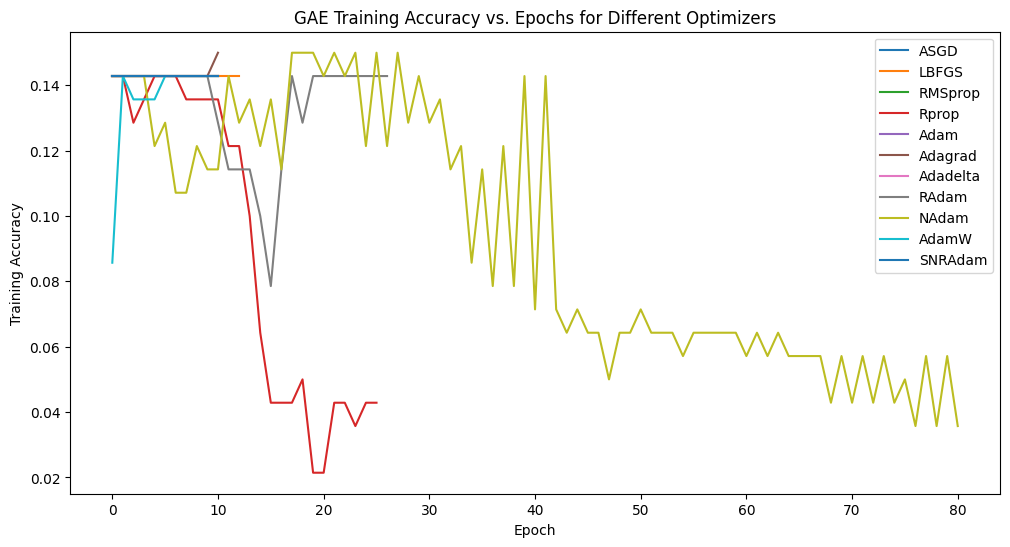

In [33]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('GAE Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

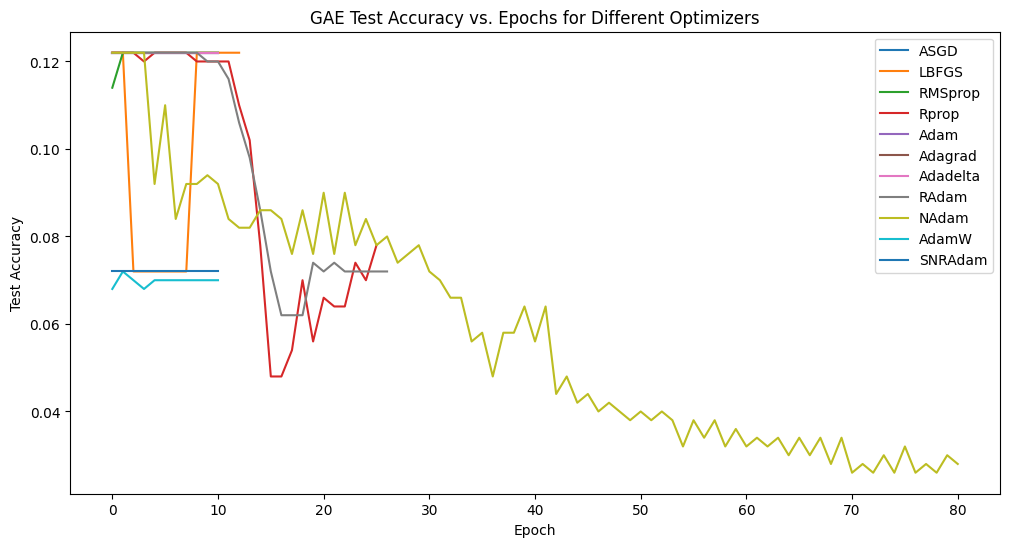

In [34]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_val_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('GAE Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

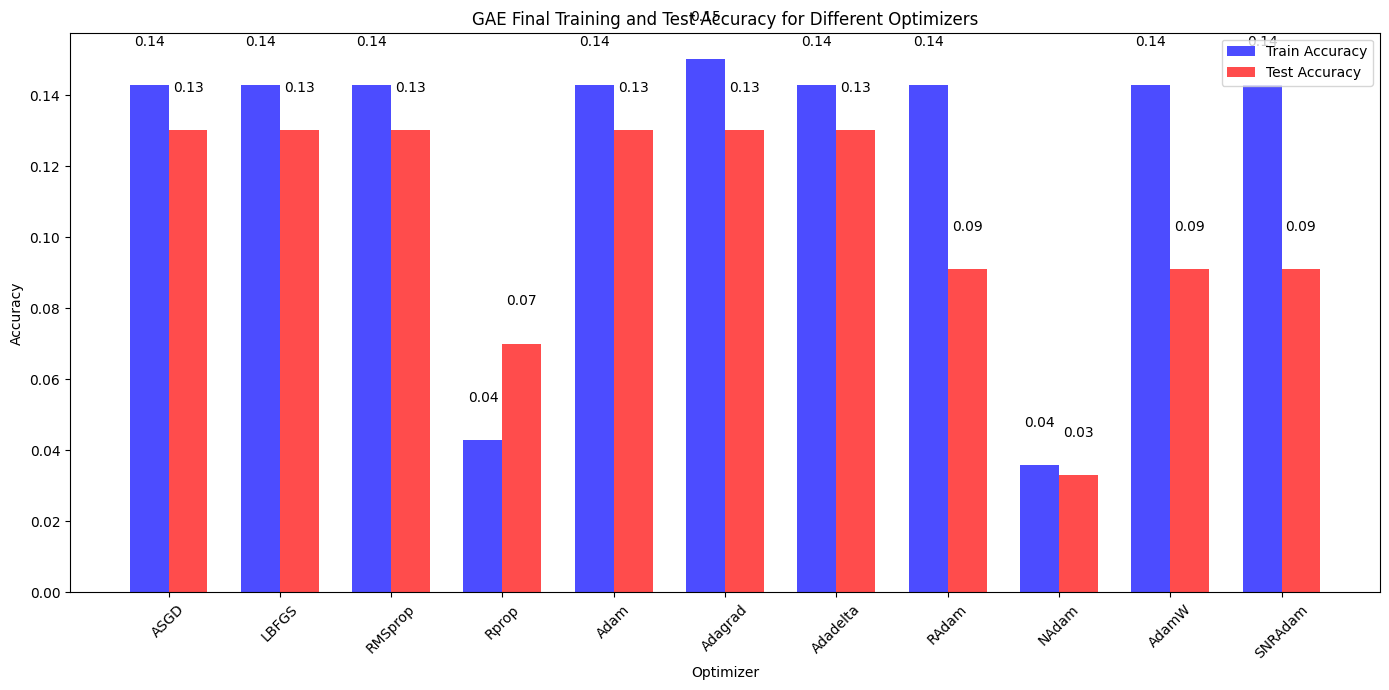

In [35]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics_list)

# Extract accuracies for plotting
train_accuracies = metrics_df['Train Accuracy']
test_accuracies = metrics_df['Test Accuracy']
optimizers_list = metrics_df['Optimizer']

# Convert to lists for plotting
x = np.arange(len(optimizers_list))
bar_width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_accuracies, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_accuracies, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('GAE Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

DGNN

In [92]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GAE
import torch.nn as nn
import torch.optim as optim

# --------------------------- DGNN Model Definition ---------------------------
class DynamicGATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=8):
        super(DynamicGATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 128, heads=heads, dropout=0.3)
        self.conv2 = GATConv(128 * heads, out_channels, heads=1, concat=False, dropout=0.3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        return self.conv2(x, edge_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_channels = 16
num_features = dataset.num_features

model = GAE(DynamicGATEncoder(num_features, out_channels)).to(device)
x = data.x.to(device)
edge_index = data.edge_index.to(device)
criterion = nn.CrossEntropyLoss()

In [93]:
# --------------------------- Node Classifier Definition ---------------------------
class NodeClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(NodeClassifier, self).__init__()
        self.linear = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)

classifier = NodeClassifier(out_channels, dataset.num_classes).to(device)
labels = data.y.to(device)
train_mask = data.train_mask.to(device)
val_mask = data.val_mask.to(device)
test_mask = data.test_mask.to(device)


In [94]:
# --------------------------- Training and Evaluation Functions ---------------------------

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, edge_index)
    loss = model.recon_loss(z, edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)

def evaluate_model(embeddings, mask):
    classifier.eval()
    with torch.no_grad():
        out = classifier(embeddings)
        pred = out[mask].max(1)[1]
        acc = pred.eq(labels[mask]).sum().item() / mask.sum().item()
    return acc

def train_classifier(embeddings):
    classifier.train()
    optimizer.zero_grad()
    out = classifier(embeddings)
    loss = criterion(out[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test_classifier(mask, embeddings):
    classifier.eval()
    with torch.no_grad():
        out = classifier(embeddings)
        pred = out[mask].max(1)[1]
        acc = pred.eq(labels[mask]).sum().item() / mask.sum().item()
    return acc

def train_model(model, criterion, optimizer, data, num_epochs=25, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        z = model.encode(data.x.to(device), data.edge_index.to(device))
        loss = model.recon_loss(z, data.edge_index.to(device))
        loss.backward()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                z = model.encode(data.x.to(device), data.edge_index.to(device))
                loss = model.recon_loss(z, data.edge_index.to(device))
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        embeddings = model.encode(data.x.to(device), data.edge_index.to(device)).detach()
        train_acc = evaluate_model(embeddings, data.train_mask)
        val_acc = evaluate_model(embeddings, data.val_mask)
        test_acc = evaluate_model(embeddings, data.test_mask)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch}/{num_epochs - 1}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

        if early_stopping:
            early_stopping(val_acc, model, epoch)
            if early_stopping.early_stop:
                early_stopping.load_best_model(model)
                break

    return model, train_accuracies, val_accuracies, test_accuracies

def evaluate_classification_performance(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model.encode(data.x.to(device), data.edge_index.to(device)).detach()
        out = classifier(embeddings)
        _, pred = out.max(dim=1)

    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()

    train_report = classification_report(y_true[data.train_mask.cpu().numpy()], y_pred[data.train_mask.cpu().numpy()], output_dict=True)
    test_report = classification_report(y_true[data.test_mask.cpu().numpy()], y_pred[data.test_mask.cpu().numpy()], output_dict=True)

    return train_report, test_report

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=25, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    embeddings = model.encode(data.x.to(device), data.edge_index.to(device)).detach()
    train_acc = evaluate_model(embeddings, data.train_mask)
    val_acc = evaluate_model(embeddings, data.val_mask)
    test_acc = evaluate_model(embeddings, data.test_mask)

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    # Evaluate the model and store metrics
    train_metrics, test_metrics = evaluate_classification_performance(model, data)

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics

# Different optimizers
lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam': SNRAdam(model.parameters(), lr=lr)
}

In [95]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GATConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1120
Epoch 1/199, Training Accuracy: 0.1000, Validation Accuracy: 0.1120
Epoch 2/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1000
Epoch 3/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1260
Epoch 4/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1240
Epoch 5/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1060
Epoch 6/199, Training Accuracy: 0.0786, Validation Accuracy: 0.1160
Epoch 7/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1340
Epoch 8/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1040
Epoch 9/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1180
Epoch 10/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1100
Epoch 11/199, Training Accuracy: 0.1214, Validation Accuracy: 0.0920
Epoch 12/199, Training Accuracy: 0.1286, Validation Accuracy: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

--------------------------------------------------
Optimizer: LBFGS
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1100
Epoch 1/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1240
Epoch 2/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1040
Epoch 3/199, Training Accuracy: 0.0929, Validation Accuracy: 0.1260
Epoch 4/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1180
Epoch 5/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1380
Epoch 6/199, Training Accuracy: 0.1143, Validation Accuracy: 0.1200
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1340
Epoch 8/199, Training Accuracy: 0.1143, Validation Accuracy: 0.1200
Epoch 9/199, Training Accuracy: 0.1000, Validation Accuracy: 0.1180
Epoch 10/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1280
Epoch 11/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1240
Epoch 12/199, Training Accuracy: 0.1143, Validation Accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

--------------------------------------------------
Optimizer: RMSprop
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1860
Epoch 1/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1080
Epoch 2/199, Training Accuracy: 0.1286, Validation Accuracy: 0.0820
Epoch 3/199, Training Accuracy: 0.1000, Validation Accuracy: 0.0900
Epoch 4/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1040
Epoch 5/199, Training Accuracy: 0.0857, Validation Accuracy: 0.0940
Epoch 6/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1060
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.0820
Epoch 8/199, Training Accuracy: 0.0786, Validation Accuracy: 0.0800
Epoch 9/199, Training Accuracy: 0.1071, Validation Accuracy: 0.0820
Epoch 10/199, Training Accuracy: 0.0857, Validation Accuracy: 0.0840
Epoch 11/199, Training Accuracy: 0.0714, Validation Accuracy: 0.0940
Epoch 12/199, Training Accuracy: 0.1000, Validation Accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

--------------------------------------------------
Optimizer: Rprop
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1643, Validation Accuracy: 0.1560
Epoch 1/199, Training Accuracy: 0.1286, Validation Accuracy: 0.0780
Epoch 2/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1640
Epoch 3/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1340
Epoch 4/199, Training Accuracy: 0.1929, Validation Accuracy: 0.1260
Epoch 5/199, Training Accuracy: 0.1929, Validation Accuracy: 0.1420
Epoch 6/199, Training Accuracy: 0.1857, Validation Accuracy: 0.1560
Epoch 7/199, Training Accuracy: 0.1714, Validation Accuracy: 0.1360
Epoch 8/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1320
Epoch 9/199, Training Accuracy: 0.1786, Validation Accuracy: 0.1260
Epoch 10/199, Training Accuracy: 0.1786, Validation Accuracy: 0.1580
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1220
Train Accuracy: 0.1929, Validation Accuracy: 0.1640, Test Accur

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------------------
Optimizer: Adagrad
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1360
Epoch 1/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1520
Epoch 2/199, Training Accuracy: 0.2143, Validation Accuracy: 0.2120
Epoch 3/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1160
Epoch 4/199, Training Accuracy: 0.1571, Validation Accuracy: 0.2400
Epoch 5/199, Training Accuracy: 0.1357, Validation Accuracy: 0.0720
Epoch 6/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1480
Epoch 7/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1080
Epoch 8/199, Training Accuracy: 0.1643, Validation Accuracy: 0.1060
Epoch 9/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1340
Epoch 10/199, Training Accuracy: 0.0857, Validation Accuracy: 0.0760
Epoch 11/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1360
Epoch 12/199, Training Accuracy: 0.1071, Validation Accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------------------
Optimizer: Adadelta
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1300
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1040
Epoch 2/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1220
Epoch 3/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1200
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1280
Epoch 5/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1120
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1080
Epoch 7/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1120
Epoch 8/199, Training Accuracy: 0.1286, Validation Accuracy: 0.1180
Epoch 9/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1140
Epoch 10/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1060
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1180
Train Accuracy: 0.1571, Validation Accuracy: 0.1300, Test Ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

--------------------------------------------------
Optimizer: RAdam
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1560
Epoch 1/199, Training Accuracy: 0.1786, Validation Accuracy: 0.1200
Epoch 2/199, Training Accuracy: 0.1214, Validation Accuracy: 0.1640
Epoch 3/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1320
Epoch 4/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1280
Epoch 5/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1260
Epoch 6/199, Training Accuracy: 0.1000, Validation Accuracy: 0.1040
Epoch 7/199, Training Accuracy: 0.1143, Validation Accuracy: 0.1060
Epoch 8/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1040
Epoch 9/199, Training Accuracy: 0.1071, Validation Accuracy: 0.1080
Epoch 10/199, Training Accuracy: 0.1000, Validation Accuracy: 0.0880
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1040
Epoch 12/199, Training Accuracy: 0.1357, Validation Accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

--------------------------------------------------
Optimizer: AdamW
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.2357, Validation Accuracy: 0.2380
Epoch 1/199, Training Accuracy: 0.1929, Validation Accuracy: 0.3600
Epoch 2/199, Training Accuracy: 0.2071, Validation Accuracy: 0.2320
Epoch 3/199, Training Accuracy: 0.2857, Validation Accuracy: 0.2580
Epoch 4/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1420
Epoch 5/199, Training Accuracy: 0.2000, Validation Accuracy: 0.2180
Epoch 6/199, Training Accuracy: 0.2000, Validation Accuracy: 0.2240
Epoch 7/199, Training Accuracy: 0.2071, Validation Accuracy: 0.2480
Epoch 8/199, Training Accuracy: 0.2000, Validation Accuracy: 0.2160
Epoch 9/199, Training Accuracy: 0.1571, Validation Accuracy: 0.1240
Epoch 10/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1180
Epoch 11/199, Training Accuracy: 0.1786, Validation Accuracy: 0.1820
Epoch 12/199, Training Accuracy: 0.2143, Validation Accuracy: 0

In [96]:
# Convert metrics to DataFrame for better visualization
metrics_list = []
test_metrics_list = []

for name in all_train_metrics.keys():
    train_report = all_train_metrics[name]
    test_report = all_test_metrics[name]

    row = {
        'Optimizer': name,
        'Train Accuracy': train_report['accuracy'],
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_report['accuracy'],
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    }
    metrics_list.append(row)
    test_metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(metrics_df)


Evaluation Metrics:
   Optimizer  Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0       ASGD        0.107143         0.054957      0.107143        0.067075   
1      LBFGS        0.107143         0.041327      0.107143        0.055772   
2    RMSprop        0.142857         0.067239      0.142857        0.090802   
3      Rprop        0.171429         0.164331      0.171429        0.161155   
4       Adam        0.128571         0.030744      0.128571        0.049082   
5    Adagrad        0.121429         0.101908      0.121429        0.099145   
6   Adadelta        0.142857         0.033798      0.142857        0.047712   
7      RAdam        0.128571         0.098701      0.128571        0.080022   
8      NAdam        0.228571         0.245313      0.228571        0.190771   
9      AdamW        0.100000         0.233375      0.100000        0.102511   
10   SNRAdam        0.078571         0.086151      0.078571        0.060383   

    Test Accuracy  Test Precis

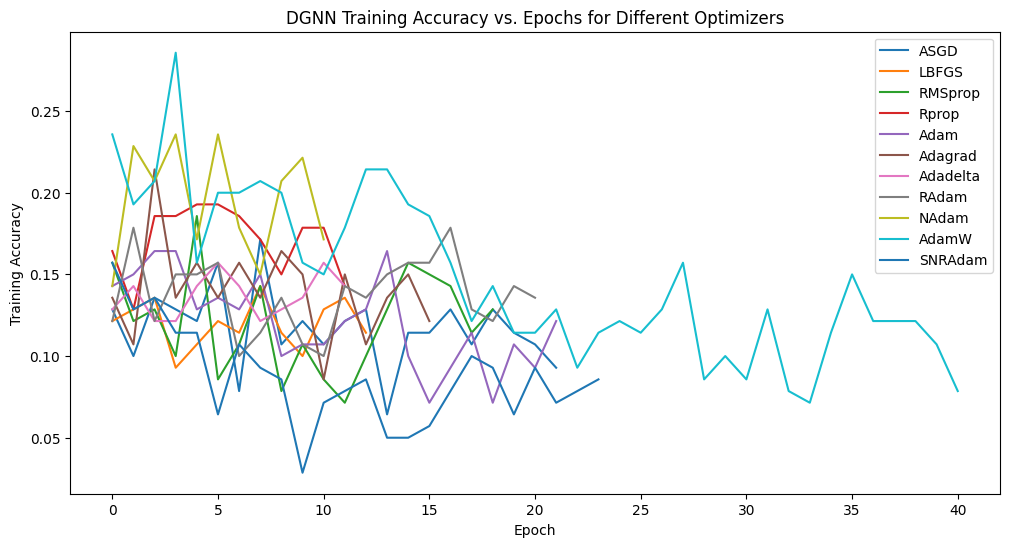

In [97]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('DGNN Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

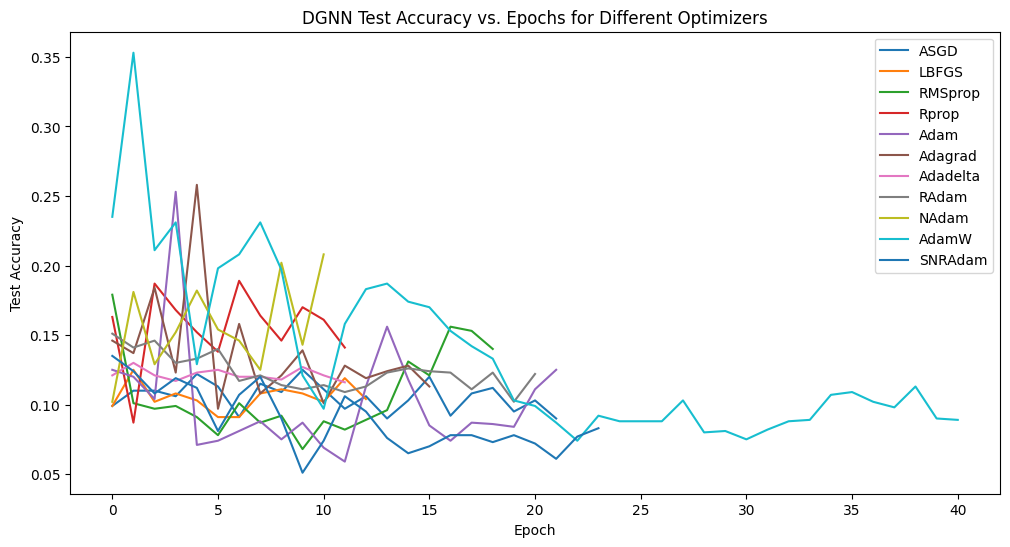

In [98]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('DGNN Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

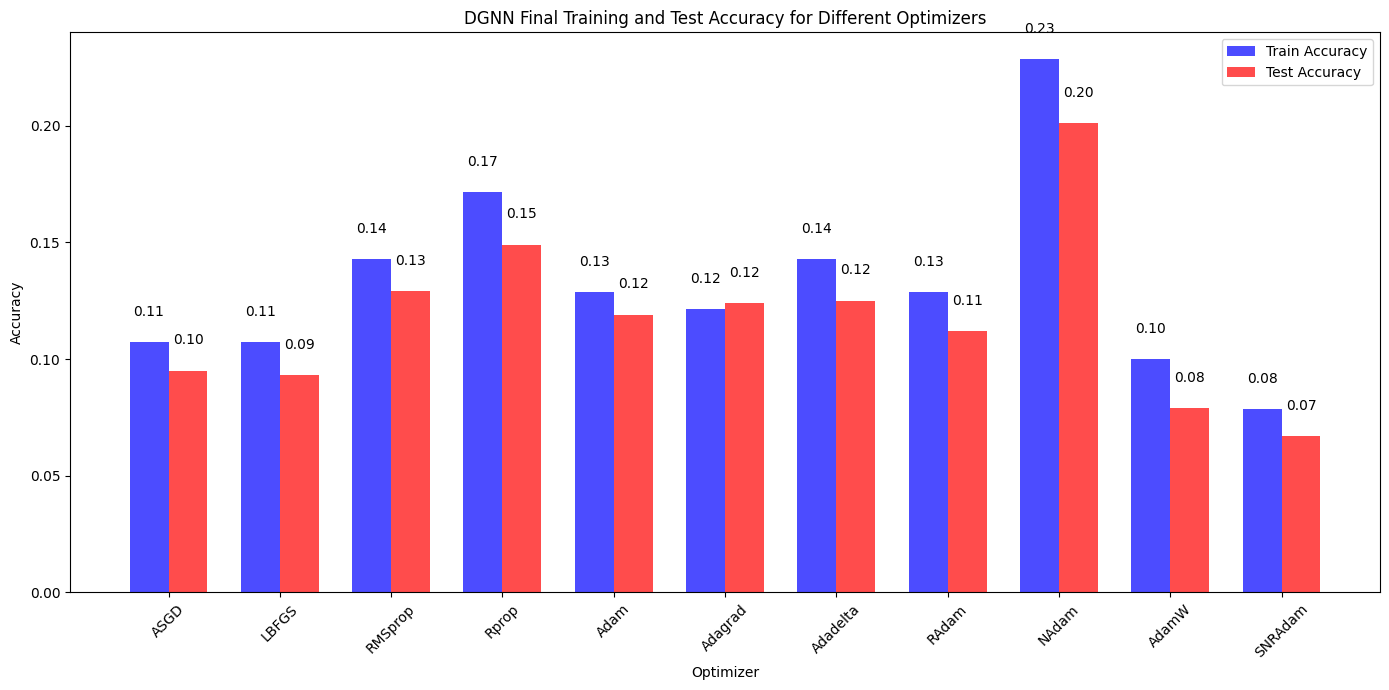

In [101]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics_list)

# Extract accuracies for plotting
train_accuracies = metrics_df['Train Accuracy']
test_accuracies = metrics_df['Test Accuracy']
optimizers_list = metrics_df['Optimizer']

# Convert to lists for plotting
x = np.arange(len(optimizers_list))
bar_width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_accuracies, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_accuracies, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('DGNN Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

GIN


In [102]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv

class GIN(nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        # Define the GIN convolutional layers
        self.conv1 = GINConv(nn.Sequential(
            nn.Linear(dataset.num_node_features, 128), nn.ReLU(), nn.Linear(128, 128)))

        self.conv2 = GINConv(nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 64)))

        self.conv3 = GINConv(nn.Sequential(
            nn.Linear(64, 16), nn.ReLU(), nn.Linear(16, 16)))

        self.conv4 = GINConv(nn.Sequential(
            nn.Linear(16, dataset.num_classes), nn.ReLU(), nn.Linear(dataset.num_classes, dataset.num_classes)))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply the GIN layers with ReLU activations and dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv4(x, edge_index)

        return F.log_softmax(x, dim=1)

# Instantiate and print model
model = GIN()
print(model)


GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1433, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (conv4): GINConv(nn=Sequential(
    (0): Linear(in_features=16, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=7, bias=True)
  ))
)


In [122]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')


def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    """Trains the model for a given number of epochs."""
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()

        # Special handling for LBFGS optimizer
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

            _, train_pred = out.max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())
            train_accuracies.append(train_acc)

            _, val_pred = out.max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())
            val_accuracies.append(val_acc)

            _, test_pred = out.max(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / int(data.test_mask.sum().item())
            test_accuracies.append(test_acc)

            print(f'Epoch {epoch}/{num_epochs - 1}, '
                  f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model)
                if early_stopping.early_stop:
                    print(f'Early stopping at epoch {epoch}')
                    break

    if early_stopping:
        model.load_state_dict(torch.load('checkpoint.pt', weights_only=True))  # Fixed here
    return model, train_accuracies, val_accuracies, test_accuracies


def evaluate_model(model, data):
    """Evaluates the model and returns classification reports."""
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, pred = out.max(dim=1)

    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()

    train_report = classification_report(
        y_true[data.train_mask.cpu().numpy()],
        y_pred[data.train_mask.cpu().numpy()],
        output_dict=True,
        zero_division=0  # Fixed here
    )
    test_report = classification_report(
        y_true[data.test_mask.cpu().numpy()],
        y_pred[data.test_mask.cpu().numpy()],
        output_dict=True,
        zero_division=0  # Fixed here
    )

    return train_report, test_report


In [123]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, GINConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1600
Epoch 1/199, Training Accuracy: 0.1143, Validation Accuracy: 0.0820
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 3/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1620
Epoch 4/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 5/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 6/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 7/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 8/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 9/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1640
Epoch 10/199, Training Accuracy: 0.1500, Validation Accuracy: 0.1640
Epoch 11/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 12/199, Training Accuracy: 0.1429, Validation Accuracy: 0.

In [124]:
# Convert metrics to DataFrame for better visualization
metrics_list = []
test_metrics_list = []

for name in all_train_metrics.keys():
    train_report = all_train_metrics[name]
    test_report = all_test_metrics[name]

    row = {
        'Optimizer': name,
        'Train Accuracy': train_report['accuracy'],
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_report['accuracy'],
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    }
    metrics_list.append(row)
    test_metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(metrics_df)


Evaluation Metrics:
   Optimizer  Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0       ASGD        0.150000         0.036264      0.150000        0.047619   
1      LBFGS        0.142857         0.021322      0.142857        0.037106   
2    RMSprop        0.142857         0.020408      0.142857        0.035714   
3      Rprop        0.185714         0.058351      0.185714        0.088518   
4       Adam        0.185714         0.155125      0.185714        0.135670   
5    Adagrad        0.442857         0.427230      0.442857        0.426514   
6   Adadelta        0.335714         0.309735      0.335714        0.277135   
7      RAdam        0.535714         0.529729      0.535714        0.495350   
8      NAdam        0.200000         0.090101      0.200000        0.104435   
9      AdamW        0.142857         0.020408      0.142857        0.035714   
10   SNRAdam        0.464286         0.468880      0.464286        0.408229   

    Test Accuracy  Test Precis

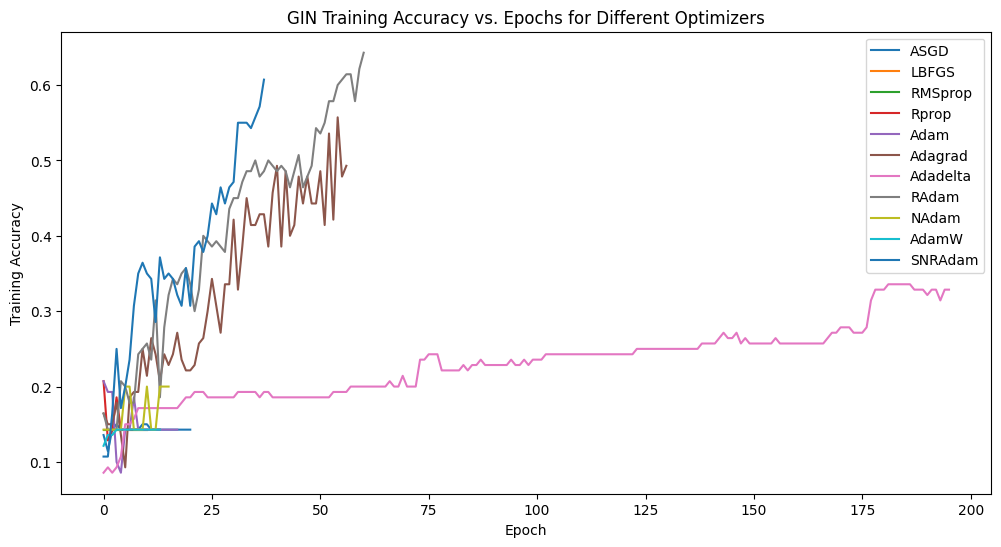

In [125]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('GIN Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

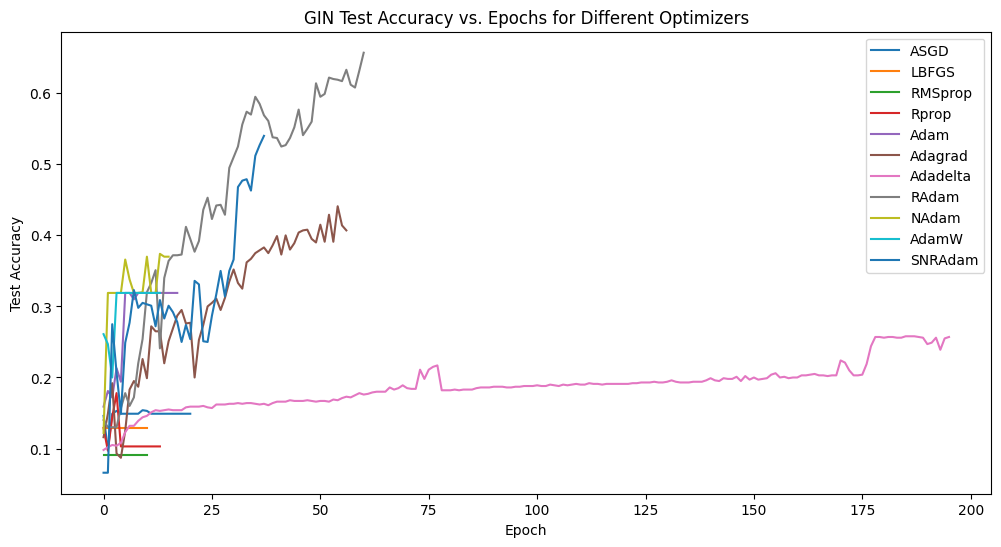

In [126]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('GIN Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

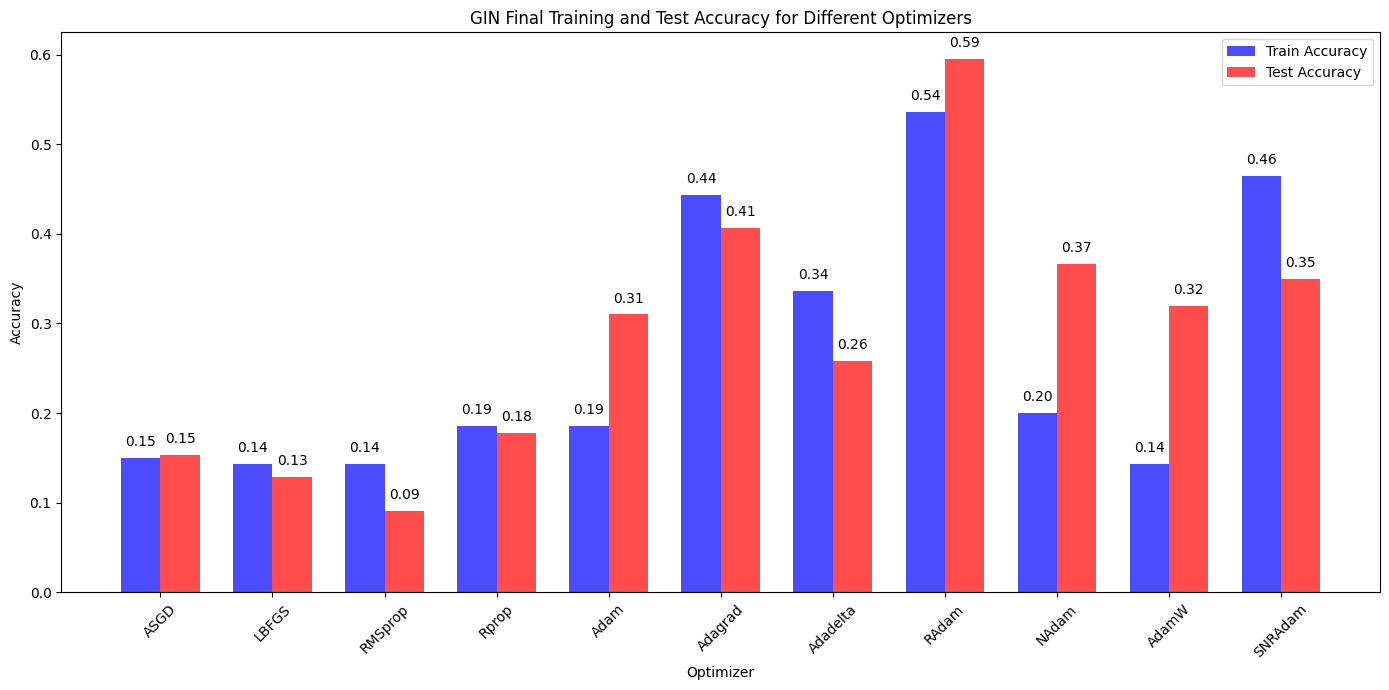

In [128]:
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics_list)

# Extract accuracies for plotting
train_accuracies = metrics_df['Train Accuracy']
test_accuracies = metrics_df['Test Accuracy']
optimizers_list = metrics_df['Optimizer']

# Convert to lists for plotting
x = np.arange(len(optimizers_list))
bar_width = 0.35

plt.figure(figsize=(14, 7))

# Plot bars
bars_train = plt.bar(x - bar_width / 2, train_accuracies, width=bar_width, color='blue', alpha=0.7, label='Train Accuracy')
bars_test = plt.bar(x + bar_width / 2, test_accuracies, width=bar_width, color='red', alpha=0.7, label='Test Accuracy')

# Add text annotations
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('GIN Final Training and Test Accuracy for Different Optimizers')
plt.xticks(x, optimizers_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

EDGECONV

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import EdgeConv
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from SNRAdam import SNRAdam  # Importing the custom SNRAdam optimizer

class EdgeConvModel(torch.nn.Module):
    def __init__(self):
        super(EdgeConvModel, self).__init__()
        self.conv1 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * dataset.num_node_features, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        ))
        self.conv2 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * 128, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        ))
        self.conv3 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * 64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        ))
        self.conv4 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * 32, dataset.num_classes)
        ))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model = None

    def __call__(self, val_loss, model, epoch):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model = model.state_dict()
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Early stopping at epoch {epoch}")

    def load_best_model(self, model):
        model.load_state_dict(self.best_model)

def train_model(model, criterion, optimizer, data, num_epochs=200, early_stopping=None):
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[data.train_mask], data.y[data.train_mask])
                loss.backward()
                return loss
            optimizer.step(closure)
        else:
            optimizer.step()

        model.eval()
        with torch.no_grad():
            _, train_pred = model(data).max(dim=1)
            train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
            train_acc = train_correct / int(data.train_mask.sum().item())
            train_accuracies.append(train_acc)

            _, val_pred = model(data).max(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / int(data.val_mask.sum().item())
            val_accuracies.append(val_acc)

            _, test_pred = out.max(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / int(data.test_mask.sum().item())
            test_accuracies.append(test_acc)

            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            print(f'Epoch {epoch}/{num_epochs - 1}, '
                  f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

            if early_stopping:
                early_stopping(val_loss.item(), model, epoch)
                if early_stopping.early_stop:
                    early_stopping.load_best_model(model)
                    break

    return model, train_accuracies, val_accuracies, test_accuracies

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        _, pred = out.max(dim=1)

    y_true = data.y.cpu().numpy()
    y_pred = pred.cpu().numpy()

    # Setting zero_division=1 to handle labels with no predicted samples
    train_report = classification_report(
        y_true[data.train_mask.cpu().numpy()],
        y_pred[data.train_mask.cpu().numpy()],
        output_dict=True,
        zero_division=1
    )
    test_report = classification_report(
        y_true[data.test_mask.cpu().numpy()],
        y_pred[data.test_mask.cpu().numpy()],
        output_dict=True,
        zero_division=1
    )

    return train_report, test_report

def train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10):
    early_stopping = EarlyStopping(patience=patience, delta=0.001)
    model, train_accuracies, val_accuracies, test_accuracies = train_model(model, criterion, optimizer, data, num_epochs, early_stopping)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = correct / int(data.train_mask.sum())

    correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = correct / int(data.val_mask.sum())

    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = correct / int(data.test_mask.sum())

    print(f'Train Accuracy: {max(train_accuracies):.4f}, Validation Accuracy: {max(val_accuracies):.4f}, Test Accuracy: {max(test_accuracies):.4f}')

    # Evaluate the model and store metrics
    train_metrics, test_metrics = evaluate_model(model, data)

    return train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics

lr = 0.01
optimizers = {
    'ASGD': torch.optim.ASGD(model.parameters(), lr=lr, lambd=0.0001, alpha=0.75, t0=1e6, weight_decay=0),
    'LBFGS': torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=100, line_search_fn="strong_wolfe"),
    'RMSprop': torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False),
    'Rprop': torch.optim.Rprop(model.parameters(), lr=lr, etas=(0.5, 1.2), step_sizes=(1e-06, 50)),
    'Adam': torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4),
    'Adagrad': torch.optim.Adagrad(model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0),
    'Adadelta': torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0),
    'RAdam': torch.optim.RAdam(model.parameters(), lr=lr),
    'NAdam': torch.optim.NAdam(model.parameters(), lr=lr),
    'AdamW': torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2),
    'SNRAdam': SNRAdam(model.parameters(), lr=0.01)
}


In [114]:
# Store results for plotting
all_train_accuracies = {}
all_val_accuracies = {}
all_test_accuracies = {}
all_train_metrics = {}
all_test_metrics = {}

for name, optimizer in optimizers.items():
    print("-" * 50)
    print(f"Optimizer: {name}")
    print("-" * 50)

    # Reset model weights
    model.apply(lambda m: isinstance(m, (nn.Linear, nn.Conv2d, EdgeConv)) and m.reset_parameters())
    model = model.to(device)

    train_acc, val_acc, test_acc, train_accuracies, val_accuracies, test_accuracies, train_metrics, test_metrics = train_and_evaluate(model, optimizer, criterion, data, num_epochs=200, patience=10)

    all_train_accuracies[name] = train_accuracies
    all_val_accuracies[name] = val_accuracies
    all_test_accuracies[name] = test_accuracies
    all_train_metrics[name] = train_metrics
    all_test_metrics[name] = test_metrics

--------------------------------------------------
Optimizer: ASGD
--------------------------------------------------
Epoch 0/199, Training Accuracy: 0.1357, Validation Accuracy: 0.1080
Epoch 1/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 2/199, Training Accuracy: 0.1429, Validation Accuracy: 0.1140
Epoch 3/199, Training Accuracy: 0.2071, Validation Accuracy: 0.1880
Epoch 4/199, Training Accuracy: 0.2000, Validation Accuracy: 0.1680
Epoch 5/199, Training Accuracy: 0.2643, Validation Accuracy: 0.2140
Epoch 6/199, Training Accuracy: 0.2286, Validation Accuracy: 0.1900
Epoch 7/199, Training Accuracy: 0.2071, Validation Accuracy: 0.1800
Epoch 8/199, Training Accuracy: 0.2071, Validation Accuracy: 0.1820
Epoch 9/199, Training Accuracy: 0.2071, Validation Accuracy: 0.1860
Epoch 10/199, Training Accuracy: 0.2071, Validation Accuracy: 0.1840
Epoch 11/199, Training Accuracy: 0.2071, Validation Accuracy: 0.1880
Epoch 12/199, Training Accuracy: 0.2071, Validation Accuracy: 0.

In [116]:
# Convert metrics to DataFrame for better visualization
metrics_list = []
test_metrics_list = []

for name in all_train_metrics.keys():
    train_report = all_train_metrics[name]
    test_report = all_test_metrics[name]

    row = {
        'Optimizer': name,
        'Train Accuracy': train_report['accuracy'],
        'Train Precision': train_report['weighted avg']['precision'],
        'Train Recall': train_report['weighted avg']['recall'],
        'Train F1-Score': train_report['weighted avg']['f1-score'],
        'Test Accuracy': test_report['accuracy'],
        'Test Precision': test_report['weighted avg']['precision'],
        'Test Recall': test_report['weighted avg']['recall'],
        'Test F1-Score': test_report['weighted avg']['f1-score']
    }
    metrics_list.append(row)
    test_metrics_list.append(row)

metrics_df = pd.DataFrame(metrics_list)
print("\nEvaluation Metrics:")
print(metrics_df)


Evaluation Metrics:
   Optimizer  Train Accuracy  Train Precision  Train Recall  Train F1-Score  \
0       ASGD        0.278571         0.615860      0.278571        0.193791   
1      LBFGS        0.171429         0.795015      0.171429        0.081322   
2    RMSprop        0.142857         0.877551      0.142857        0.035714   
3      Rprop        0.142857         0.877551      0.142857        0.035714   
4       Adam        0.142857         0.877551      0.142857        0.035714   
5    Adagrad        0.192857         0.633730      0.192857        0.092590   
6   Adadelta        0.207143         0.675015      0.207143        0.111389   
7      RAdam        0.664286         0.744979      0.664286        0.623018   
8      NAdam        0.142857         0.877551      0.142857        0.035714   
9      AdamW        0.142857         0.877551      0.142857        0.035714   
10   SNRAdam        0.142857         0.877551      0.142857        0.035714   

    Test Accuracy  Test Precis

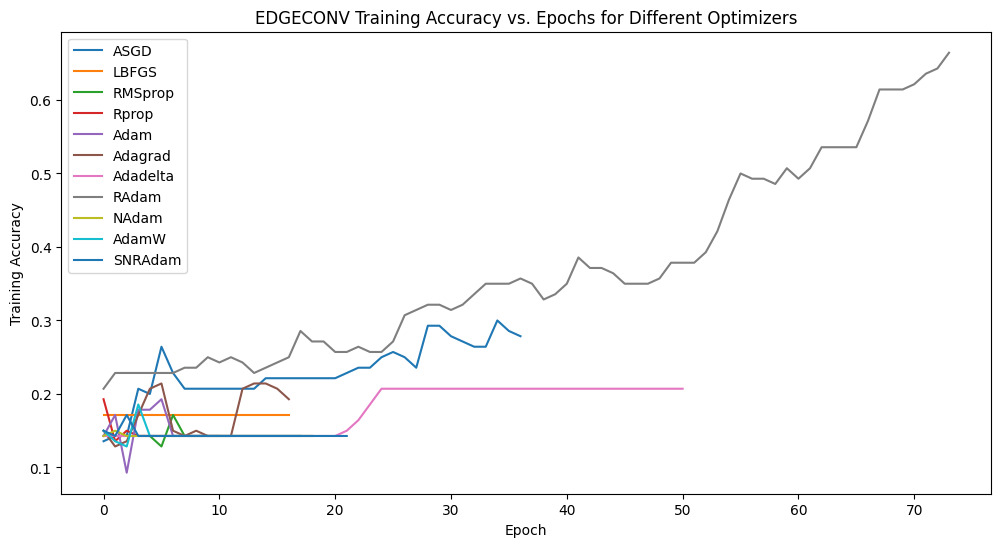

In [117]:
# Plot training accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('EDGECONV Training Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()

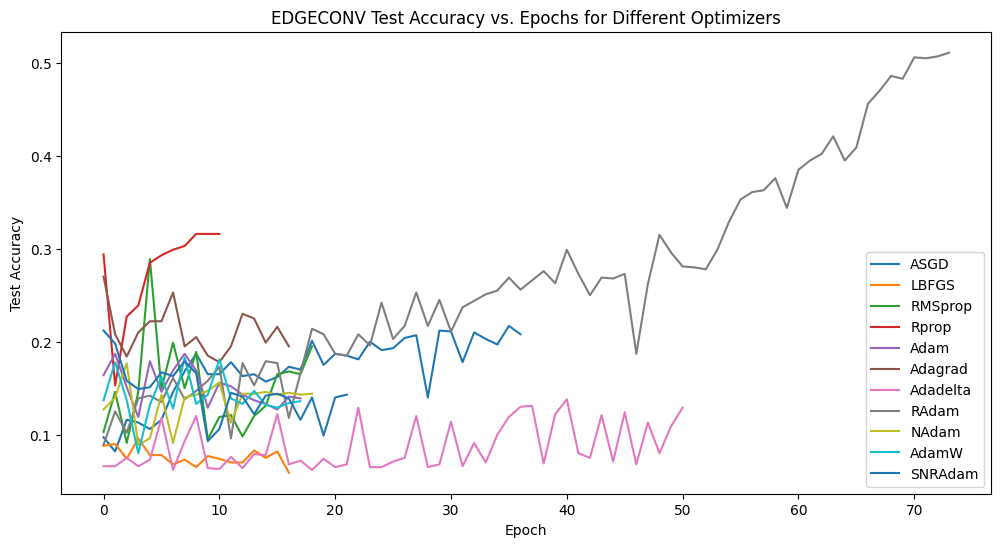

In [118]:
# Plot test accuracies
plt.figure(figsize=(12, 6))
for name, accuracies in all_test_accuracies.items():
    plt.plot(accuracies, label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('EDGECONV Test Accuracy vs. Epochs for Different Optimizers')
plt.legend()
plt.show()